In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'LSTM Images Experiments - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Performance Metrics Functions

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## Cyclic Stocks

### Singapore Airlines

In [8]:
nr_test_sets = ['C6L.SI']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


In [9]:
r_test_sets = ['C6L.SI']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0


### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


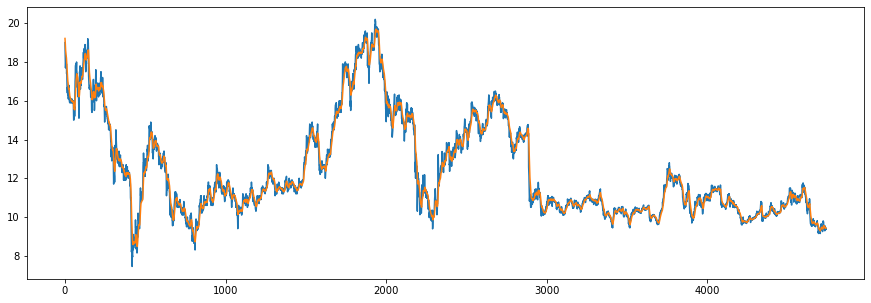

In [10]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/C6L.SI_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [11]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4725, 15, 1)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [13]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64)
y = np.array(y)

X.shape

(4725, 64, 64)

In [14]:
from collections import Counter

Counter(y)

Counter({2.0: 4297, 0.0: 215, 1.0: 213})

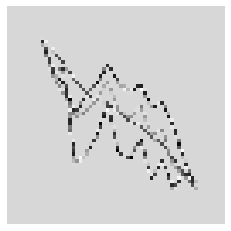

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('C6L.SI')]
    y = nr_test_data['{}_y'.format('C6L.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('C6L.SI'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'C6L.SI')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'C6L.SI'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'C6L.SI'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('C6L.SI')]
    y = r_test_data['{}_y'.format('C6L.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('C6L.SI'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'C6L.SI')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'C6L.SI'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'C6L.SI'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.325581395348837, 1: 7.411764705882353, 2: 0.36649214659685864}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 7s 239ms/step - loss: 0.2879 - accuracy: 0.4608 - mse: 0.4293 - weighted_accuracy: 0.3658 - weighted_mse: 0.4617 - val_loss: 0.2893 - val_accuracy: 0.9090 - val_mse: 0.3418 - val_weighted_accuracy: 0.9090 - val_weighted_mse: 0.3418
Epoch 2/20
30/30 [==============================] - 0s 17ms/step - loss: 0.2202 - accuracy: 0.3780 - mse: 0.6882 - weighted_accuracy: 0.4262 - weighted_mse: 0.6917 - val_loss: 0.2856 - val_accuracy: 0.0497 - val_mse: 0.3770 - val_weighted_accuracy: 0.0497 - val_weighted_mse: 0.3770
Epoch 3/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1959 - accuracy: 0.3534 - mse: 0.9334 - weighted_accuracy: 0.4726 - weighted_mse: 0.9334 - val_loss: 0.2834 - val_accuracy: 0.0455 - val_mse: 0.3863 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.3863
Epoch 4/20
30/30 [==============================] - 0

Epoch 1/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1352 - accuracy: 0.4717 - mse: 1.5121 - weighted_accuracy: 0.7435 - weighted_mse: 1.4585 - val_loss: 0.1709 - val_accuracy: 0.6106 - val_mse: 0.9410 - val_weighted_accuracy: 0.6106 - val_weighted_mse: 0.9410
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1322 - accuracy: 0.5185 - mse: 1.5497 - weighted_accuracy: 0.7589 - weighted_mse: 1.5208 - val_loss: 0.2067 - val_accuracy: 0.4995 - val_mse: 2.6260 - val_weighted_accuracy: 0.4995 - val_weighted_mse: 2.6260
Epoch 3/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1298 - accuracy: 0.5304 - mse: 1.5609 - weighted_accuracy: 0.7650 - weighted_mse: 1.5393 - val_loss: 0.1846 - val_accuracy: 0.5873 - val_mse: 2.2169 - val_weighted_accuracy: 0.5873 - val_weighted_mse: 2.2169
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1267 - accuracy: 0.5341 - mse: 1.5670 - weighted_accuracy: 0.7868 - weighted

0           -64.1546  


Recession Test


7/7 [==============================] - 0s 6ms/step - loss: 0.1186 - accuracy: 0.8512 - mse: 3.8295 - weighted_accuracy: 0.8512 - weighted_mse: 3.8295
Test loss: 0.11864778399467468
Test accuracy: 0.8511627912521362


number of predictions: 215
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 9
actual holds but predicted sell: 7
actual predicted holds: 182
Percentage buys correct: 10.0%
Percentage sells correct: 0.0%
Percentage holds correct: 91.91919191919192%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 80.0%
Percentage high sells correct: 42.857142857142854%
Percentage mid holds correct: 85.27918781725889%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price

Epoch 20/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0270 - accuracy: 0.9458 - mse: 5.3352 - weighted_accuracy: 0.9764 - weighted_mse: 5.6231 - val_loss: 0.9508 - val_accuracy: 0.3228 - val_mse: 15.4663 - val_weighted_accuracy: 0.3228 - val_weighted_mse: 15.4663
Validation loss: 0.9507649540901184
Validation accuracy: 0.32275131344795227


Non-Recession Test


7/7 [==============================] - 0s 7ms/step - loss: 0.9634 - accuracy: 0.2936 - mse: 15.5112 - weighted_accuracy: 0.2936 - weighted_mse: 15.5112
Test loss: 0.9634422063827515
Test accuracy: 0.29357796907424927


number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 8
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 2
actual holds but predicted sell: 141
actual predicted holds: 57
Percentage buys correct: 0.0%
Percentage sells correct: 4.487179487179487%
Percent

30/30 [==============================] - 1s 23ms/step - loss: 0.0108 - accuracy: 0.9907 - mse: 9.4922 - weighted_accuracy: 0.9966 - weighted_mse: 9.3383 - val_loss: 0.5132 - val_accuracy: 0.6159 - val_mse: 12.4682 - val_weighted_accuracy: 0.6159 - val_weighted_mse: 12.4682
Epoch 16/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0087 - accuracy: 0.9950 - mse: 9.7533 - weighted_accuracy: 0.9982 - weighted_mse: 9.6318 - val_loss: 0.3992 - val_accuracy: 0.8667 - val_mse: 22.8807 - val_weighted_accuracy: 0.8667 - val_weighted_mse: 22.8807
Epoch 17/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0083 - accuracy: 0.9960 - mse: 9.9826 - weighted_accuracy: 0.9985 - weighted_mse: 9.8642 - val_loss: 0.4737 - val_accuracy: 0.6063 - val_mse: 10.8049 - val_weighted_accuracy: 0.6063 - val_weighted_mse: 10.8049
Epoch 18/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0075 - accuracy: 0.9966 - mse: 10.3808 - weighted_accuracy: 0.9987 - weighted_

Epoch 1/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0066 - accuracy: 0.9995 - mse: 11.2157 - weighted_accuracy: 0.9998 - weighted_mse: 10.9999 - val_loss: 0.3081 - val_accuracy: 0.8624 - val_mse: 15.2467 - val_weighted_accuracy: 0.8624 - val_weighted_mse: 15.2467
Epoch 2/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0063 - accuracy: 0.9997 - mse: 11.5527 - weighted_accuracy: 0.9999 - weighted_mse: 11.2499 - val_loss: 0.2976 - val_accuracy: 0.8190 - val_mse: 10.8837 - val_weighted_accuracy: 0.8190 - val_weighted_mse: 10.8837
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0061 - accuracy: 1.0000 - mse: 11.7539 - weighted_accuracy: 1.0000 - weighted_mse: 11.3572 - val_loss: 0.3159 - val_accuracy: 0.8677 - val_mse: 15.0860 - val_weighted_accuracy: 0.8677 - val_weighted_mse: 15.0860
Epoch 4/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0061 - accuracy: 1.0000 - mse: 11.9766 - weighted_accuracy: 1.00

Epoch 1/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0049 - accuracy: 1.0000 - mse: 15.4844 - weighted_accuracy: 1.0000 - weighted_mse: 14.7944 - val_loss: 0.3602 - val_accuracy: 0.8624 - val_mse: 18.2165 - val_weighted_accuracy: 0.8624 - val_weighted_mse: 18.2165
Epoch 2/20
30/30 [==============================] - 1s 17ms/step - loss: 0.0048 - accuracy: 1.0000 - mse: 15.7393 - weighted_accuracy: 1.0000 - weighted_mse: 14.9804 - val_loss: 0.3310 - val_accuracy: 0.8593 - val_mse: 15.5557 - val_weighted_accuracy: 0.8593 - val_weighted_mse: 15.5557
Epoch 3/20
30/30 [==============================] - 1s 17ms/step - loss: 0.0047 - accuracy: 1.0000 - mse: 15.9009 - weighted_accuracy: 1.0000 - weighted_mse: 15.0635 - val_loss: 0.3673 - val_accuracy: 0.8561 - val_mse: 17.4489 - val_weighted_accuracy: 0.8561 - val_weighted_mse: 17.4489
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0047 - accuracy: 1.0000 - mse: 16.0584 - weighted_accuracy: 1.00

Epoch 1/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0044 - accuracy: 1.0000 - mse: 18.6638 - weighted_accuracy: 1.0000 - weighted_mse: 17.6960 - val_loss: 0.4190 - val_accuracy: 0.8741 - val_mse: 22.2618 - val_weighted_accuracy: 0.8741 - val_weighted_mse: 22.2618
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0045 - accuracy: 1.0000 - mse: 18.8114 - weighted_accuracy: 1.0000 - weighted_mse: 17.7402 - val_loss: 0.3536 - val_accuracy: 0.8593 - val_mse: 17.0745 - val_weighted_accuracy: 0.8593 - val_weighted_mse: 17.0745
Epoch 3/20
30/30 [==============================] - 1s 17ms/step - loss: 0.0044 - accuracy: 1.0000 - mse: 19.0015 - weighted_accuracy: 1.0000 - weighted_mse: 17.8960 - val_loss: 0.4092 - val_accuracy: 0.8423 - val_mse: 19.6610 - val_weighted_accuracy: 0.8423 - val_weighted_mse: 19.6610
Epoch 4/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0044 - accuracy: 1.0000 - mse: 19.1016 - weighted_accuracy: 1.00

Epoch 1/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0043 - accuracy: 1.0000 - mse: 21.2099 - weighted_accuracy: 1.0000 - weighted_mse: 20.0874 - val_loss: 0.4381 - val_accuracy: 0.8667 - val_mse: 23.1971 - val_weighted_accuracy: 0.8667 - val_weighted_mse: 23.1971
Epoch 2/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0043 - accuracy: 1.0000 - mse: 21.3164 - weighted_accuracy: 1.0000 - weighted_mse: 20.0960 - val_loss: 0.4352 - val_accuracy: 0.8847 - val_mse: 25.3702 - val_weighted_accuracy: 0.8847 - val_weighted_mse: 25.3702
Epoch 3/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0043 - accuracy: 1.0000 - mse: 21.4516 - weighted_accuracy: 1.0000 - weighted_mse: 20.1143 - val_loss: 0.4325 - val_accuracy: 0.8423 - val_mse: 21.7923 - val_weighted_accuracy: 0.8423 - val_weighted_mse: 21.7923
Epoch 4/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0043 - accuracy: 1.0000 - mse: 21.5505 - weighted_accuracy: 1.00

Epoch 1/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 23.4138 - weighted_accuracy: 1.0000 - weighted_mse: 22.0071 - val_loss: 0.4579 - val_accuracy: 0.8635 - val_mse: 24.2790 - val_weighted_accuracy: 0.8635 - val_weighted_mse: 24.2790
Epoch 2/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 23.5249 - weighted_accuracy: 1.0000 - weighted_mse: 22.0536 - val_loss: 0.4775 - val_accuracy: 0.8762 - val_mse: 28.2852 - val_weighted_accuracy: 0.8762 - val_weighted_mse: 28.2852
Epoch 3/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 23.6208 - weighted_accuracy: 1.0000 - weighted_mse: 21.9952 - val_loss: 0.4583 - val_accuracy: 0.8434 - val_mse: 23.5611 - val_weighted_accuracy: 0.8434 - val_weighted_mse: 23.5611
Epoch 4/20
30/30 [==============================] - 1s 29ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 23.7094 - weighted_accuracy: 1.00

Epoch 1/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 25.2680 - weighted_accuracy: 1.0000 - weighted_mse: 23.6966 - val_loss: 0.4763 - val_accuracy: 0.8646 - val_mse: 25.9485 - val_weighted_accuracy: 0.8646 - val_weighted_mse: 25.9485
Epoch 2/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 25.3580 - weighted_accuracy: 1.0000 - weighted_mse: 23.7112 - val_loss: 0.4895 - val_accuracy: 0.8772 - val_mse: 29.6283 - val_weighted_accuracy: 0.8772 - val_weighted_mse: 29.6283
Epoch 3/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0040 - accuracy: 1.0000 - mse: 25.4460 - weighted_accuracy: 1.0000 - weighted_mse: 23.6153 - val_loss: 0.4765 - val_accuracy: 0.8455 - val_mse: 25.3642 - val_weighted_accuracy: 0.8455 - val_weighted_mse: 25.3642
Epoch 4/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0040 - accuracy: 1.0000 - mse: 25.5200 - weighted_accuracy: 1.00

In [22]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.534884,0.000000,5.263158,91.666667,0.000000,37.894737,85.714286,0.000000,-78.238355
1,0.851163,10.000000,0.000000,91.919192,80.000000,42.857143,85.279188,103.870599,-78.238355
2,0.306977,0.000000,5.228758,95.081967,0.000000,46.405229,91.666667,-10.016748,-78.238355
3,0.734884,15.384615,0.000000,91.764706,53.846154,37.500000,85.207101,413.196633,-78.238355
4,0.832558,22.222222,0.000000,92.187500,66.666667,35.714286,86.387435,896.312926,-78.238355
5,0.888372,25.000000,0.000000,92.233010,50.000000,40.000000,86.341463,540.284317,-78.238355
6,0.888372,25.000000,0.000000,92.233010,50.000000,40.000000,86.341463,540.284317,-78.238355
7,0.888372,25.000000,0.000000,92.233010,50.000000,40.000000,86.341463,540.284317,-78.238355
8,0.883721,25.000000,0.000000,92.195122,50.000000,33.333333,86.274510,540.284317,-78.238355
9,0.883721,33.333333,0.000000,92.610837,50.000000,33.333333,86.633663,259.832516,-78.238355


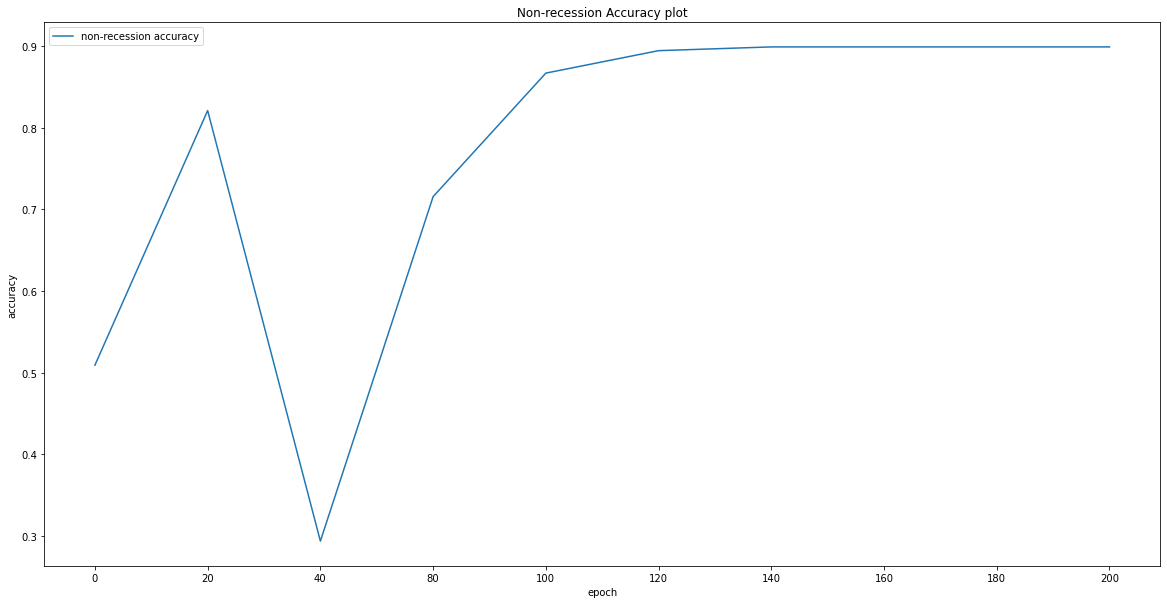

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

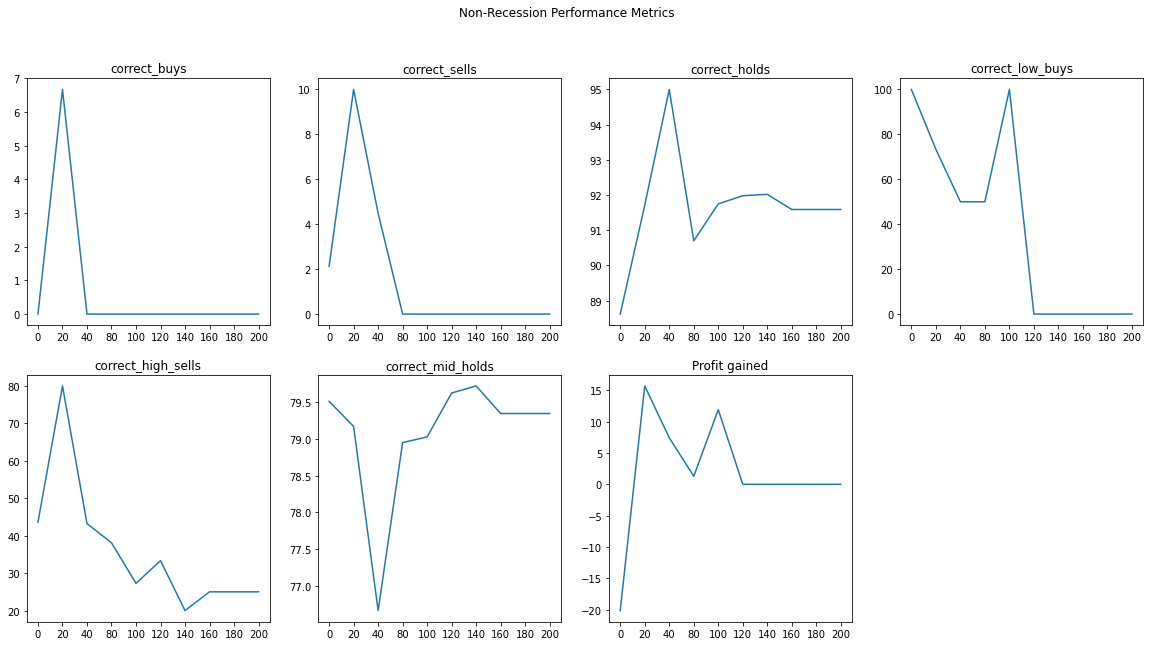

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

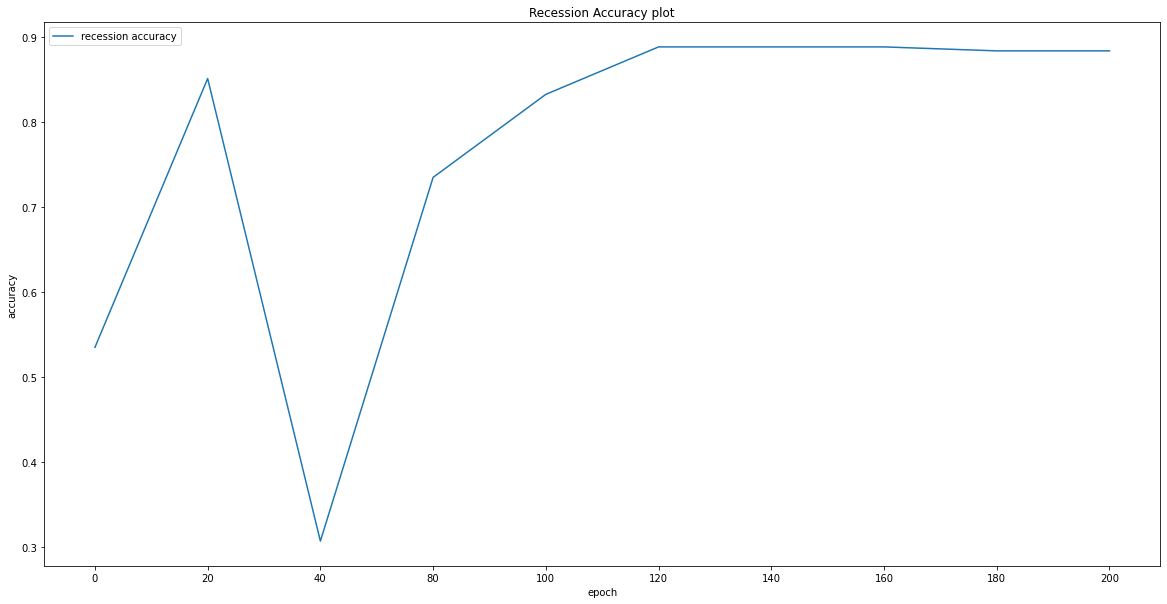

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

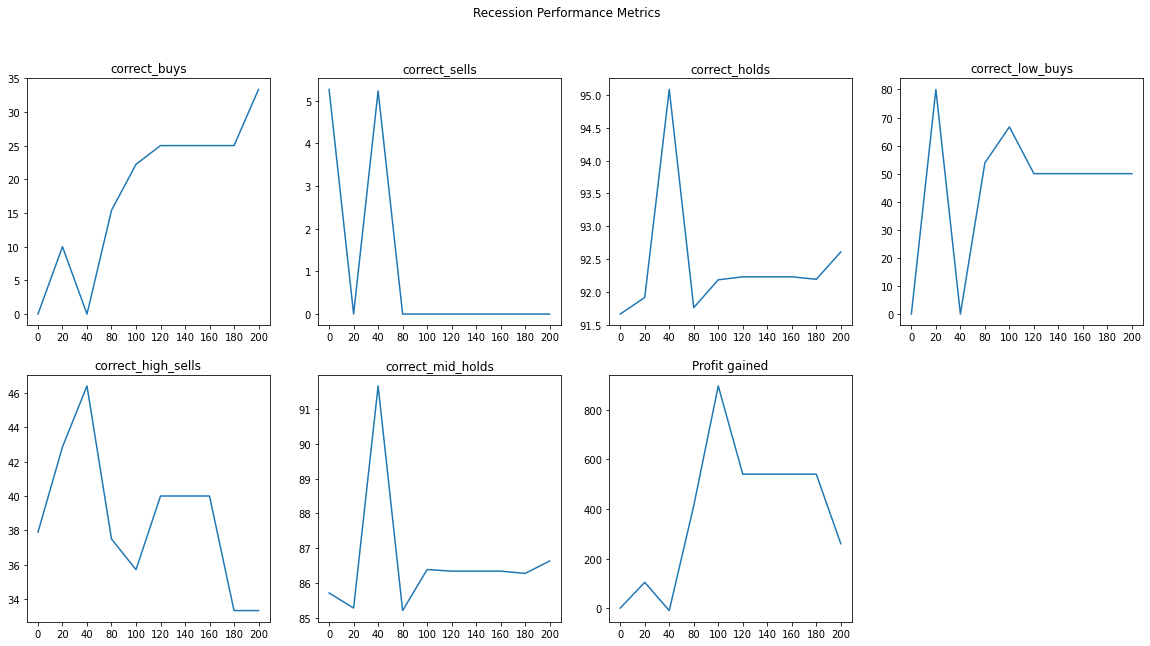

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### OCBC Bank

In [27]:
nr_test_sets = ['O39.SI']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0


In [28]:
r_test_sets = ['O39.SI']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0


### training Data

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


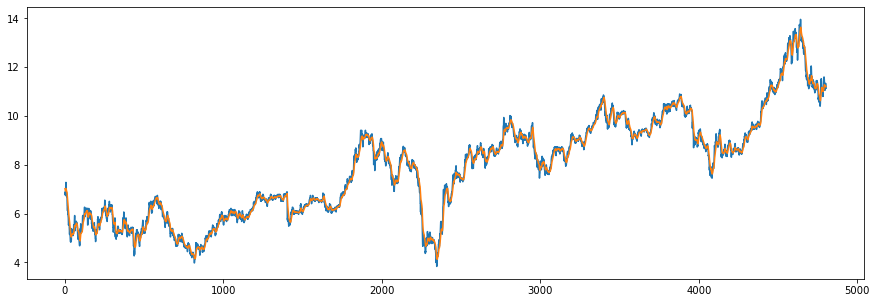

(4789, 64, 64)

In [29]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/O39.SI_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64)
y = np.array(y)

X.shape

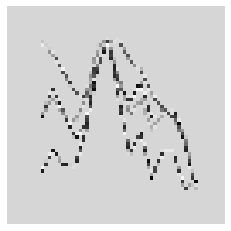

In [30]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [31]:
X = X/255

In [32]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [33]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [34]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [36]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('O39.SI')]
    y = nr_test_data['{}_y'.format('O39.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('O39.SI'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'O39.SI')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'O39.SI'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'O39.SI'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('O39.SI')]
    y = r_test_data['{}_y'.format('O39.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('O39.SI'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'O39.SI')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'O39.SI'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'O39.SI'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.255681818181818, 1: 7.931677018633541, 2: 0.3654836863194047}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 2s 77ms/step - loss: 0.2742 - accuracy: 0.4853 - mse: 0.4338 - weighted_accuracy: 0.4183 - weighted_mse: 0.4558 - val_loss: 0.2924 - val_accuracy: 0.7985 - val_mse: 0.3485 - val_weighted_accuracy: 0.7985 - val_weighted_mse: 0.3485
Epoch 2/20
30/30 [==============================] - 1s 31ms/step - loss: 0.2111 - accuracy: 0.3767 - mse: 0.7160 - weighted_accuracy: 0.4916 - weighted_mse: 0.6918 - val_loss: 0.2938 - val_accuracy: 0.0459 - val_mse: 0.3920 - val_weighted_accuracy: 0.0459 - val_weighted_mse: 0.3920
Epoch 3/20
30/30 [==============================] - 1s 32ms/step - loss: 0.1868 - accuracy: 0.3602 - mse: 0.9700 - weighted_accuracy: 0.5241 - weighted_mse: 0.9299 - val_loss: 0.2865 - val_accuracy: 0.0418 - val_mse: 0.3973 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3973
Epoch 4/20
30/30 [==============================] - 1s 

0          -24.56292  



RUNNING EPOCHS 20 - 40



Epoch 1/20
30/30 [==============================] - 1s 36ms/step - loss: 0.1187 - accuracy: 0.5463 - mse: 1.8142 - weighted_accuracy: 0.7781 - weighted_mse: 1.8164 - val_loss: 0.1943 - val_accuracy: 0.4353 - val_mse: 1.8009 - val_weighted_accuracy: 0.4353 - val_weighted_mse: 1.8009
Epoch 2/20
30/30 [==============================] - 1s 33ms/step - loss: 0.1160 - accuracy: 0.5897 - mse: 1.8554 - weighted_accuracy: 0.7999 - weighted_mse: 1.8826 - val_loss: 0.1268 - val_accuracy: 0.8069 - val_mse: 1.7134 - val_weighted_accuracy: 0.8069 - val_weighted_mse: 1.7134
Epoch 3/20
30/30 [==============================] - 1s 34ms/step - loss: 0.1127 - accuracy: 0.5808 - mse: 1.9401 - weighted_accuracy: 0.7966 - weighted_mse: 1.9720 - val_loss: 0.1385 - val_accuracy: 0.7516 - val_mse: 2.7059 - val_weighted_accuracy: 0.7516 - val_weighted_mse: 2.7059
Epoch 4/20
30/30 [==============================] - 1s 31ms/step - loss: 0.1087 - accuracy: 0.6058 

Epoch 1/20
30/30 [==============================] - 1s 35ms/step - loss: 0.0495 - accuracy: 0.8700 - mse: 3.5395 - weighted_accuracy: 0.9507 - weighted_mse: 4.0369 - val_loss: 0.2358 - val_accuracy: 0.6858 - val_mse: 7.0615 - val_weighted_accuracy: 0.6858 - val_weighted_mse: 7.0615
Epoch 2/20
30/30 [==============================] - 1s 32ms/step - loss: 0.0469 - accuracy: 0.8815 - mse: 3.7676 - weighted_accuracy: 0.9529 - weighted_mse: 4.3169 - val_loss: 0.1419 - val_accuracy: 0.9019 - val_mse: 9.0948 - val_weighted_accuracy: 0.9019 - val_weighted_mse: 9.0948
Epoch 3/20
30/30 [==============================] - 1s 32ms/step - loss: 0.0449 - accuracy: 0.8930 - mse: 3.9756 - weighted_accuracy: 0.9533 - weighted_mse: 4.5101 - val_loss: 0.2735 - val_accuracy: 0.9102 - val_mse: 15.9905 - val_weighted_accuracy: 0.9102 - val_weighted_mse: 15.9905
Epoch 4/20
30/30 [==============================] - 1s 32ms/step - loss: 0.0406 - accuracy: 0.9039 - mse: 4.1674 - weighted_accuracy: 0.9631 - weight

Epoch 1/20
30/30 [==============================] - 1s 34ms/step - loss: 0.0108 - accuracy: 0.9883 - mse: 8.6963 - weighted_accuracy: 0.9957 - weighted_mse: 9.7284 - val_loss: 0.3179 - val_accuracy: 0.9019 - val_mse: 22.6736 - val_weighted_accuracy: 0.9019 - val_weighted_mse: 22.6736
Epoch 2/20
30/30 [==============================] - 1s 32ms/step - loss: 0.0101 - accuracy: 0.9911 - mse: 9.0284 - weighted_accuracy: 0.9968 - weighted_mse: 10.0895 - val_loss: 0.3325 - val_accuracy: 0.9019 - val_mse: 19.3190 - val_weighted_accuracy: 0.9019 - val_weighted_mse: 19.3190
Epoch 3/20
30/30 [==============================] - 1s 32ms/step - loss: 0.0092 - accuracy: 0.9943 - mse: 9.3171 - weighted_accuracy: 0.9979 - weighted_mse: 10.4605 - val_loss: 0.3326 - val_accuracy: 0.9081 - val_mse: 21.2067 - val_weighted_accuracy: 0.9081 - val_weighted_mse: 21.2067
Epoch 4/20
30/30 [==============================] - 1s 30ms/step - loss: 0.0086 - accuracy: 0.9945 - mse: 9.6621 - weighted_accuracy: 0.9980 - 

Epoch 1/20
30/30 [==============================] - 1s 32ms/step - loss: 0.0063 - accuracy: 0.9992 - mse: 11.6922 - weighted_accuracy: 0.9997 - weighted_mse: 12.5228 - val_loss: 0.3218 - val_accuracy: 0.8173 - val_mse: 15.8832 - val_weighted_accuracy: 0.8173 - val_weighted_mse: 15.8832
Epoch 2/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0062 - accuracy: 0.9992 - mse: 11.9965 - weighted_accuracy: 0.9997 - weighted_mse: 12.7838 - val_loss: 0.2926 - val_accuracy: 0.8424 - val_mse: 16.2094 - val_weighted_accuracy: 0.8424 - val_weighted_mse: 16.2094
Epoch 3/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0059 - accuracy: 1.0000 - mse: 12.2253 - weighted_accuracy: 1.0000 - weighted_mse: 13.0834 - val_loss: 0.2817 - val_accuracy: 0.8434 - val_mse: 14.1215 - val_weighted_accuracy: 0.8434 - val_weighted_mse: 14.1215
Epoch 4/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0059 - accuracy: 0.9992 - mse: 12.4839 - weighted_accuracy: 0.99

7/7 [==============================] - 0s 5ms/step - loss: 0.2761 - accuracy: 0.8698 - mse: 15.9354 - weighted_accuracy: 0.8698 - weighted_mse: 15.9354
Test loss: 0.27609968185424805
Test accuracy: 0.869767427444458


number of predictions: 215
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 3
actual holds but predicted sell: 5
actual predicted holds: 185
Percentage buys correct: 0.0%
Percentage sells correct: 25.0%
Percentage holds correct: 90.68627450980392%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 37.5%
Percentage mid holds correct: 86.69950738916256%


Capital: 100
Share price: $0.26609744573760596
Shares owned at the moment: 374
Cash capital at the moment: $0.20587407119423062


Price increase from previously bought: -18.

Cash capital at the moment: $0.36060391234076405


Price increase from previously bought: -65.66352223412757%
Share price: $0.14496889442240968
Shares owned at the moment: 0
Cash capital at the moment: $34.4791781835493


Share price: $0.5560118571548094
Shares owned at the moment: 61
Cash capital at the moment: $0.4691839080682101


Price increase from previously bought: 10.729417602550395%
Share price: $0.6173617801295237
Shares owned at the moment: 0
Cash capital at the moment: $38.02469005735243


Share price: $0.07748444721120527
Shares owned at the moment: 489
Cash capital at the moment: $0.030598160685784137


Price increase from previously bought: 449.79545687237163%
Share price: $0.4271774869688898
Shares owned at the moment: 0
Cash capital at the moment: $208.34594236287148




Capital at the end of test period: $208.34594236287148
profit gained: 108.34594236287147%


Capital at the end of test period if Buy and Hold: $44.097971344241664
profit gained: -55.90202865575834%
   

30/30 [==============================] - 1s 19ms/step - loss: 0.0043 - accuracy: 1.0000 - mse: 20.5482 - weighted_accuracy: 1.0000 - weighted_mse: 21.2483 - val_loss: 0.3807 - val_accuracy: 0.8685 - val_mse: 21.8087 - val_weighted_accuracy: 0.8685 - val_weighted_mse: 21.8087
Epoch 18/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0043 - accuracy: 1.0000 - mse: 20.6483 - weighted_accuracy: 1.0000 - weighted_mse: 21.6297 - val_loss: 0.3819 - val_accuracy: 0.8768 - val_mse: 21.9761 - val_weighted_accuracy: 0.8768 - val_weighted_mse: 21.9761
Epoch 19/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0043 - accuracy: 1.0000 - mse: 20.7443 - weighted_accuracy: 1.0000 - weighted_mse: 21.6343 - val_loss: 0.3772 - val_accuracy: 0.8507 - val_mse: 20.0719 - val_weighted_accuracy: 0.8507 - val_weighted_mse: 20.0719
Epoch 20/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0043 - accuracy: 1.0000 - mse: 20.9135 - weighted_accuracy: 1.0000 - wei

30/30 [==============================] - 1s 20ms/step - loss: 0.0043 - accuracy: 1.0000 - mse: 21.9530 - weighted_accuracy: 1.0000 - weighted_mse: 22.6956 - val_loss: 0.3856 - val_accuracy: 0.8727 - val_mse: 21.7167 - val_weighted_accuracy: 0.8727 - val_weighted_mse: 21.7167
Epoch 11/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0043 - accuracy: 1.0000 - mse: 22.0023 - weighted_accuracy: 1.0000 - weighted_mse: 22.6531 - val_loss: 0.3868 - val_accuracy: 0.8674 - val_mse: 22.0432 - val_weighted_accuracy: 0.8674 - val_weighted_mse: 22.0432
Epoch 12/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 22.1824 - weighted_accuracy: 1.0000 - weighted_mse: 23.1702 - val_loss: 0.3864 - val_accuracy: 0.8716 - val_mse: 21.6569 - val_weighted_accuracy: 0.8716 - val_weighted_mse: 21.6569
Epoch 13/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 22.2409 - weighted_accuracy: 1.0000 - wei

30/30 [==============================] - 1s 19ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 23.2997 - weighted_accuracy: 1.0000 - weighted_mse: 24.0632 - val_loss: 0.3993 - val_accuracy: 0.8497 - val_mse: 21.4439 - val_weighted_accuracy: 0.8497 - val_weighted_mse: 21.4439
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 23.4347 - weighted_accuracy: 1.0000 - weighted_mse: 24.3623 - val_loss: 0.4118 - val_accuracy: 0.8445 - val_mse: 22.2419 - val_weighted_accuracy: 0.8445 - val_weighted_mse: 22.2419
Epoch 5/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 23.5631 - weighted_accuracy: 1.0000 - weighted_mse: 24.2872 - val_loss: 0.4100 - val_accuracy: 0.8810 - val_mse: 24.2124 - val_weighted_accuracy: 0.8810 - val_weighted_mse: 24.2124
Epoch 6/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 23.6367 - weighted_accuracy: 1.0000 - weight

profit gained: -3.399612241561812%


Capital at the end of test period if Buy and Hold: $75.43708035614208
profit gained: -24.562919643857924%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.851163           0.0            0.0      89.705882   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0              50.0                20.0          85.714286      -3.399612   

   buy_n_hold profit  
0          -24.56292  



RUNNING EPOCHS 180 - 200



Epoch 1/20
30/30 [==============================] - 1s 35ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 24.9917 - weighted_accuracy: 1.0000 - weighted_mse: 25.6478 - val_loss: 0.4242 - val_accuracy: 0.8643 - val_mse: 23.6322 - val_weighted_accuracy: 0.8643 - val_weighted_mse: 23.6322
Epoch 2/20
30/30 [==============================] - 1s 31ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 25.0857 - weighted_accuracy: 1.0000 - weighted_mse: 25.5875 - val_loss: 0.4286 - val_accuracy: 0.8570 -

7/7 [==============================] - 0s 9ms/step - loss: 0.3945 - accuracy: 0.8512 - mse: 24.9513 - weighted_accuracy: 0.8512 - weighted_mse: 24.9513
Test loss: 0.3944510817527771
Test accuracy: 0.8511627912521362


number of predictions: 215
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 6
actual holds but predicted sell: 4
actual predicted holds: 183
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 89.70588235294117%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.0%
Percentage high sells correct: 20.0%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.26609744573760596
Shares owned at the moment: 374
Cash capital at the moment: $0.20587407119423062


Price increase from previously bought: -18.5557666083946

In [37]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.851163,0.000000,0.000000,89.268293,0.000000,40.000000,85.294118,0.000000,-24.56292
1,0.846512,7.142857,0.000000,90.049751,57.142857,0.000000,86.000000,-20.851718,-24.56292
2,0.893023,0.000000,0.000000,89.719626,0.000000,0.000000,85.915493,173.046470,-24.56292
3,0.823256,0.000000,5.882353,90.256410,100.000000,29.411765,86.082474,135.474627,-24.56292
4,0.869767,0.000000,25.000000,90.686275,66.666667,37.500000,86.699507,12.254669,-24.56292
5,0.851163,0.000000,0.000000,89.705882,60.000000,16.666667,85.714286,18.892033,-24.56292
6,0.851163,0.000000,0.000000,89.705882,60.000000,16.666667,85.714286,18.892033,-24.56292
7,0.851163,0.000000,0.000000,89.705882,50.000000,20.000000,85.714286,-3.399612,-24.56292
8,0.851163,0.000000,0.000000,89.705882,50.000000,20.000000,85.714286,-3.399612,-24.56292
9,0.851163,0.000000,0.000000,89.705882,50.000000,20.000000,85.714286,-3.399612,-24.56292


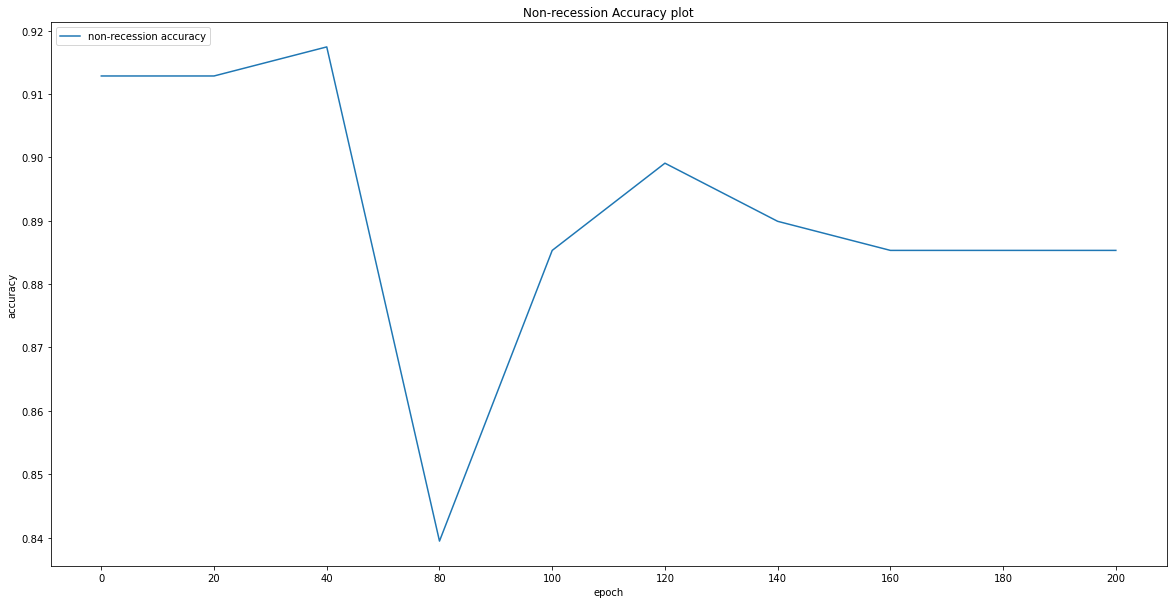

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

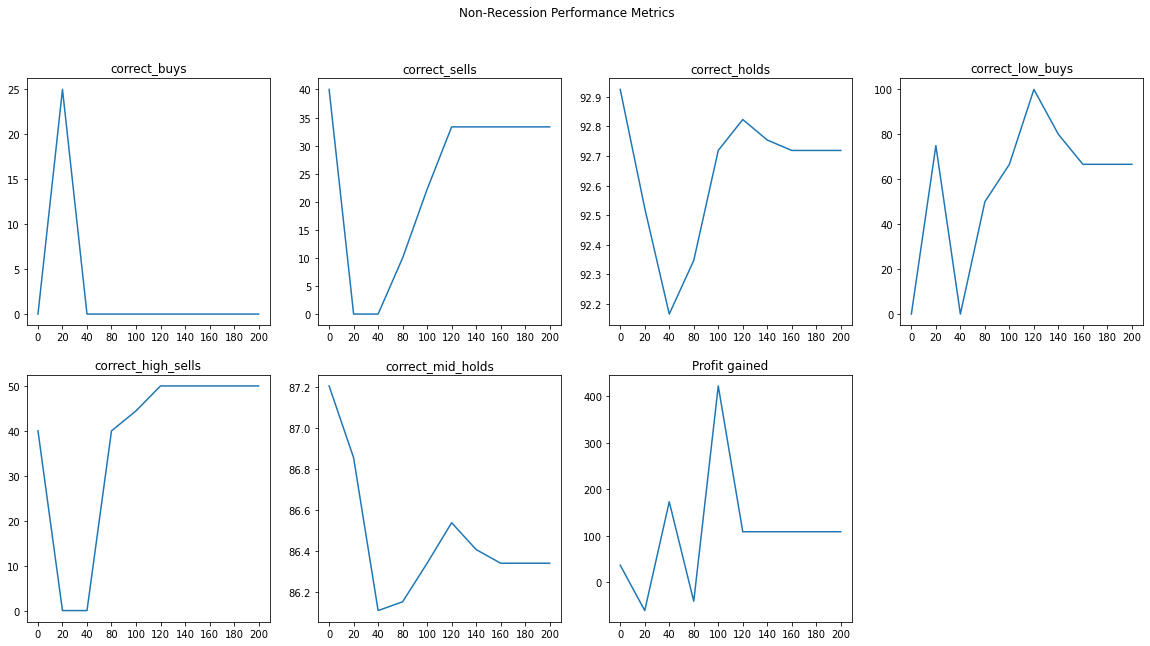

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

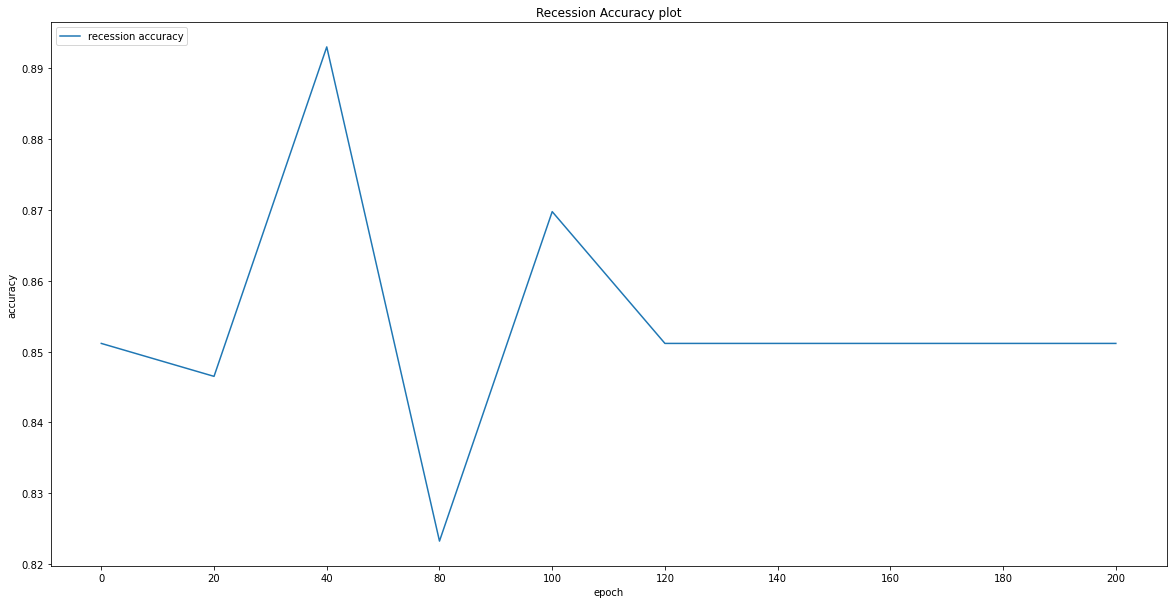

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

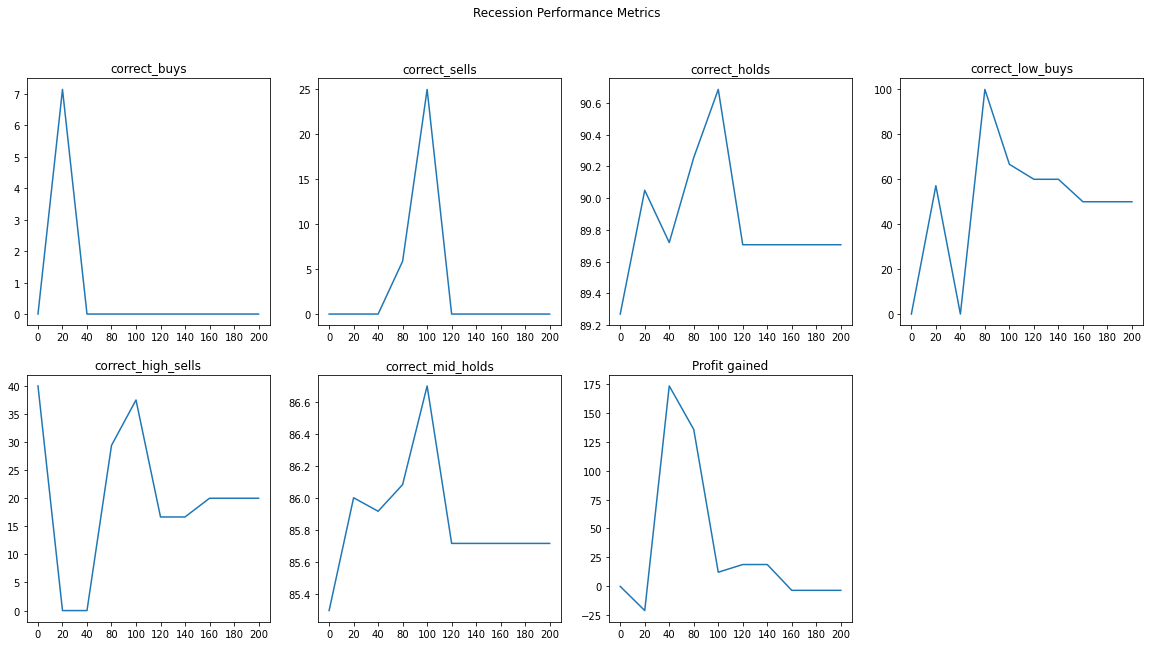

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### CNOOC Limited

In [42]:
nr_test_sets = ['0883.HK']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22        13.12  12.552209  -3.030323  489168111.0     2.0
2019-01-23        12.94  12.611869 -13.043517  449876554.0     2.0
2019-01-24        12.62  12.613120 -33.333352  395082483.0     2.0
2019-01-25        12.80  12.641871 -37.254896  441807090.0     2.0
2019-01-28        13.06  12.706198 -11.764689  494043477.0     2.0


In [43]:
r_test_sets = ['0883.HK']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2020-01-22        13.00  13.393678 -83.870980  104646165.0     2.0
2020-01-23        13.34  13.385420 -57.377021  145802714.0     2.0
2020-01-24        13.00  13.326125 -85.245880   96260120.0     2.0
2020-01-29        13.04  13.282106 -80.645176  122828433.0     2.0
2020-01-30        12.46  13.155628 -90.804605   53693706.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


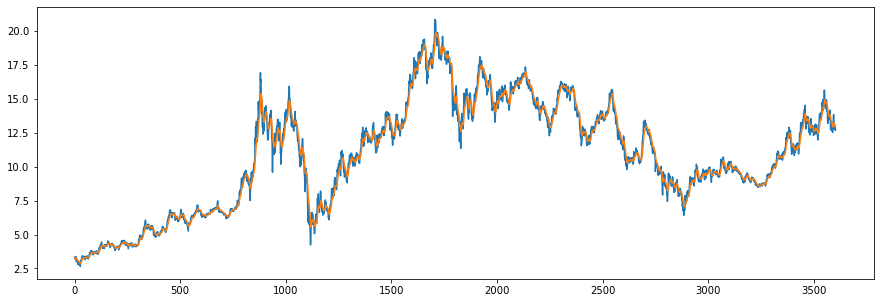

(3590, 64, 64)

In [44]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/0883.HK_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64)
y = np.array(y)

X.shape

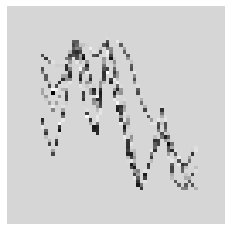

In [45]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [46]:
X = X/255

In [47]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [48]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [49]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [51]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('0883.HK')]
    y = nr_test_data['{}_y'.format('0883.HK')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('0883.HK'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'0883.HK')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'0883.HK'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'0883.HK'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('0883.HK')]
    y = r_test_data['{}_y'.format('0883.HK')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('0883.HK'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'0883.HK')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'0883.HK'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'0883.HK'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.252525252525253, 1: 7.364102564102564, 2: 0.36679438058748404}



RUNNING EPOCHS 0 - 20



Epoch 1/20
23/23 [==============================] - 1s 46ms/step - loss: 0.2895 - accuracy: 0.5035 - mse: 0.3970 - weighted_accuracy: 0.3791 - weighted_mse: 0.4514 - val_loss: 0.2933 - val_accuracy: 0.9095 - val_mse: 0.3352 - val_weighted_accuracy: 0.9095 - val_weighted_mse: 0.3352
Epoch 2/20
23/23 [==============================] - 0s 13ms/step - loss: 0.2230 - accuracy: 0.4001 - mse: 0.6185 - weighted_accuracy: 0.4499 - weighted_mse: 0.6291 - val_loss: 0.2913 - val_accuracy: 0.0446 - val_mse: 0.3609 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3609
Epoch 3/20
23/23 [==============================] - 0s 13ms/step - loss: 0.1973 - accuracy: 0.3398 - mse: 0.8470 - weighted_accuracy: 0.4806 - weighted_mse: 0.8196 - val_loss: 0.2919 - val_accuracy: 0.0446 - val_mse: 0.3775 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3775
Epoch 4/20
23/23 [==============================] - 0s

Epoch 1/20
23/23 [==============================] - 0s 14ms/step - loss: 0.1339 - accuracy: 0.4878 - mse: 1.6398 - weighted_accuracy: 0.7590 - weighted_mse: 1.6253 - val_loss: 0.1625 - val_accuracy: 0.6880 - val_mse: 0.9834 - val_weighted_accuracy: 0.6880 - val_weighted_mse: 0.9834
Epoch 2/20
23/23 [==============================] - 0s 13ms/step - loss: 0.1291 - accuracy: 0.5007 - mse: 1.6379 - weighted_accuracy: 0.7611 - weighted_mse: 1.6461 - val_loss: 0.1777 - val_accuracy: 0.5084 - val_mse: 1.2200 - val_weighted_accuracy: 0.5084 - val_weighted_mse: 1.2200
Epoch 3/20
23/23 [==============================] - 0s 13ms/step - loss: 0.1273 - accuracy: 0.4847 - mse: 1.6575 - weighted_accuracy: 0.7579 - weighted_mse: 1.6606 - val_loss: 0.1425 - val_accuracy: 0.7270 - val_mse: 1.2607 - val_weighted_accuracy: 0.7270 - val_weighted_mse: 1.2607
Epoch 4/20
23/23 [==============================] - 0s 13ms/step - loss: 0.1246 - accuracy: 0.5449 - mse: 1.6678 - weighted_accuracy: 0.7727 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.4623 - accuracy: 0.3099 - mse: 7.6804 - weighted_accuracy: 0.3099 - weighted_mse: 7.6804
Test loss: 0.4623071253299713
Test accuracy: 0.30985915660858154


number of predictions: 213
actual predicted buys: 2
actual buys but predicted sell: 5
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 23
actual holds but predicted sell: 110
actual predicted holds: 60
Percentage buys correct: 7.407407407407407%
Percentage sells correct: 3.361344537815126%
Percentage holds correct: 89.55223880597015%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 44.44444444444444%
Percentage high sells correct: 39.83050847457627%
Percentage mid holds correct: 82.08955223880596%


Capital: 100
Share price: $0.8450167531194901
Shares owned at the moment: 118
Cash capital at the moment: $0.013815195512904666


Pri

Epoch 10/20
23/23 [==============================] - 0s 13ms/step - loss: 0.0474 - accuracy: 0.8628 - mse: 3.2344 - weighted_accuracy: 0.9449 - weighted_mse: 3.7815 - val_loss: 0.2288 - val_accuracy: 0.6588 - val_mse: 4.5555 - val_weighted_accuracy: 0.6588 - val_weighted_mse: 4.5555
Epoch 11/20
23/23 [==============================] - 0s 13ms/step - loss: 0.0449 - accuracy: 0.8802 - mse: 3.3466 - weighted_accuracy: 0.9513 - weighted_mse: 3.8693 - val_loss: 0.2163 - val_accuracy: 0.8691 - val_mse: 8.2674 - val_weighted_accuracy: 0.8691 - val_weighted_mse: 8.2674
Epoch 12/20
23/23 [==============================] - 0s 13ms/step - loss: 0.0433 - accuracy: 0.8827 - mse: 3.5275 - weighted_accuracy: 0.9546 - weighted_mse: 4.0758 - val_loss: 0.2055 - val_accuracy: 0.8802 - val_mse: 8.2631 - val_weighted_accuracy: 0.8802 - val_weighted_mse: 8.2631
Epoch 13/20
23/23 [==============================] - 0s 14ms/step - loss: 0.0437 - accuracy: 0.8931 - mse: 3.6430 - weighted_accuracy: 0.9511 - weig

23/23 [==============================] - 0s 13ms/step - loss: 0.0200 - accuracy: 0.9666 - mse: 5.5687 - weighted_accuracy: 0.9877 - weighted_mse: 6.4847 - val_loss: 0.2648 - val_accuracy: 0.7242 - val_mse: 7.6873 - val_weighted_accuracy: 0.7242 - val_weighted_mse: 7.6873
Epoch 5/20
23/23 [==============================] - 0s 13ms/step - loss: 0.0184 - accuracy: 0.9687 - mse: 5.8495 - weighted_accuracy: 0.9885 - weighted_mse: 6.6611 - val_loss: 0.1951 - val_accuracy: 0.8747 - val_mse: 8.0924 - val_weighted_accuracy: 0.8747 - val_weighted_mse: 8.0924
Epoch 6/20
23/23 [==============================] - 0s 13ms/step - loss: 0.0192 - accuracy: 0.9680 - mse: 6.0817 - weighted_accuracy: 0.9883 - weighted_mse: 6.8356 - val_loss: 0.2656 - val_accuracy: 0.8287 - val_mse: 17.9158 - val_weighted_accuracy: 0.8287 - val_weighted_mse: 17.9158
Epoch 7/20
23/23 [==============================] - 0s 13ms/step - loss: 0.0189 - accuracy: 0.9669 - mse: 6.1705 - weighted_accuracy: 0.9879 - weighted_mse: 7.1

Epoch 2/20
23/23 [==============================] - 0s 13ms/step - loss: 0.0070 - accuracy: 0.9983 - mse: 9.4020 - weighted_accuracy: 0.9994 - weighted_mse: 10.5886 - val_loss: 0.3459 - val_accuracy: 0.8050 - val_mse: 13.9179 - val_weighted_accuracy: 0.8050 - val_weighted_mse: 13.9179
Epoch 3/20
23/23 [==============================] - 0s 13ms/step - loss: 0.0065 - accuracy: 0.9993 - mse: 9.5885 - weighted_accuracy: 0.9997 - weighted_mse: 10.8511 - val_loss: 0.3597 - val_accuracy: 0.8844 - val_mse: 18.6256 - val_weighted_accuracy: 0.8844 - val_weighted_mse: 18.6256
Epoch 4/20
23/23 [==============================] - 0s 13ms/step - loss: 0.0065 - accuracy: 0.9993 - mse: 9.8359 - weighted_accuracy: 0.9997 - weighted_mse: 10.9736 - val_loss: 0.3887 - val_accuracy: 0.8036 - val_mse: 17.8445 - val_weighted_accuracy: 0.8036 - val_weighted_mse: 17.8445
Epoch 5/20
23/23 [==============================] - 0s 13ms/step - loss: 0.0061 - accuracy: 1.0000 - mse: 10.0903 - weighted_accuracy: 1.0000 

Epoch 1/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0049 - accuracy: 1.0000 - mse: 12.6538 - weighted_accuracy: 1.0000 - weighted_mse: 13.8003 - val_loss: 0.3664 - val_accuracy: 0.8370 - val_mse: 15.6689 - val_weighted_accuracy: 0.8370 - val_weighted_mse: 15.6689
Epoch 2/20
23/23 [==============================] - 1s 23ms/step - loss: 0.0048 - accuracy: 1.0000 - mse: 12.8054 - weighted_accuracy: 1.0000 - weighted_mse: 14.0562 - val_loss: 0.3581 - val_accuracy: 0.8175 - val_mse: 14.6869 - val_weighted_accuracy: 0.8175 - val_weighted_mse: 14.6869
Epoch 3/20
23/23 [==============================] - 1s 25ms/step - loss: 0.0048 - accuracy: 1.0000 - mse: 12.9128 - weighted_accuracy: 1.0000 - weighted_mse: 14.1255 - val_loss: 0.3556 - val_accuracy: 0.8440 - val_mse: 15.7672 - val_weighted_accuracy: 0.8440 - val_weighted_mse: 15.7672
Epoch 4/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0048 - accuracy: 1.0000 - mse: 13.0619 - weighted_accuracy: 1.00

0         -84.289887  



RUNNING EPOCHS 120 - 140



Epoch 1/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0044 - accuracy: 1.0000 - mse: 15.0189 - weighted_accuracy: 1.0000 - weighted_mse: 16.2077 - val_loss: 0.3749 - val_accuracy: 0.8593 - val_mse: 17.5219 - val_weighted_accuracy: 0.8593 - val_weighted_mse: 17.5219
Epoch 2/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0044 - accuracy: 1.0000 - mse: 15.1569 - weighted_accuracy: 1.0000 - weighted_mse: 16.4192 - val_loss: 0.3646 - val_accuracy: 0.8482 - val_mse: 16.8817 - val_weighted_accuracy: 0.8482 - val_weighted_mse: 16.8817
Epoch 3/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0044 - accuracy: 1.0000 - mse: 15.2211 - weighted_accuracy: 1.0000 - weighted_mse: 16.4881 - val_loss: 0.3791 - val_accuracy: 0.8301 - val_mse: 15.7073 - val_weighted_accuracy: 0.8301 - val_weighted_mse: 15.7073
Epoch 4/20
23/23 [==============================] - 1s 22ms/step - loss: 0.0044 - acc

number of predictions: 213
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 9
actual holds but predicted sell: 6
actual predicted holds: 178
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 0.0%
Percentage holds correct: 90.81632653061224%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 36.36363636363637%
Percentage high sells correct: 33.333333333333336%
Percentage mid holds correct: 82.05128205128206%


Capital: 100
Share price: $0.9897979992587349
Shares owned at the moment: 100
Cash capital at the moment: $0.7480056243303466


Price increase from previously bought: -63.03324514719281%
Share price: $0.3669024144737578
Shares owned at the moment: 0
Cash capital at the moment: $37.33734890772585


Share price: $0.35006733358042164
Shares owned at the moment: 106


7/7 [==============================] - 0s 5ms/step - loss: 0.3824 - accuracy: 0.8483 - mse: 18.0661 - weighted_accuracy: 0.8483 - weighted_mse: 18.0661
Test loss: 0.38236746191978455
Test accuracy: 0.8483412265777588


number of predictions: 211
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 11
actual holds but predicted sell: 5
actual predicted holds: 178
Percentage buys correct: 0.0%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 91.75257731958763%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 45.45454545454545%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 83.41968911917098%


Capital: 100
Share price: $0.8587805297869677
Shares owned at the moment: 116
Cash capital at the moment: $0.10750755570970227


Price increase from previously 

Epoch 13/20
23/23 [==============================] - 1s 23ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 19.3539 - weighted_accuracy: 1.0000 - weighted_mse: 20.3368 - val_loss: 0.4418 - val_accuracy: 0.8496 - val_mse: 20.1888 - val_weighted_accuracy: 0.8496 - val_weighted_mse: 20.1888
Epoch 14/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 19.4631 - weighted_accuracy: 1.0000 - weighted_mse: 20.5036 - val_loss: 0.4637 - val_accuracy: 0.8092 - val_mse: 17.3576 - val_weighted_accuracy: 0.8092 - val_weighted_mse: 17.3576
Epoch 15/20
23/23 [==============================] - 1s 23ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 19.5395 - weighted_accuracy: 1.0000 - weighted_mse: 20.8553 - val_loss: 0.4637 - val_accuracy: 0.8175 - val_mse: 18.5267 - val_weighted_accuracy: 0.8175 - val_weighted_mse: 18.5267
Epoch 16/20
23/23 [==============================] - 1s 23ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 19.6071 - weighted_accuracy: 

23/23 [==============================] - 1s 24ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 20.1837 - weighted_accuracy: 1.0000 - weighted_mse: 21.2264 - val_loss: 0.4670 - val_accuracy: 0.8092 - val_mse: 19.0916 - val_weighted_accuracy: 0.8092 - val_weighted_mse: 19.0916
Epoch 7/20
23/23 [==============================] - 1s 23ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 20.2949 - weighted_accuracy: 1.0000 - weighted_mse: 21.7025 - val_loss: 0.4514 - val_accuracy: 0.8454 - val_mse: 20.4529 - val_weighted_accuracy: 0.8454 - val_weighted_mse: 20.4529
Epoch 8/20
23/23 [==============================] - 1s 23ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 20.3519 - weighted_accuracy: 1.0000 - weighted_mse: 21.5496 - val_loss: 0.4511 - val_accuracy: 0.8398 - val_mse: 20.4909 - val_weighted_accuracy: 0.8398 - val_weighted_mse: 20.4909
Epoch 9/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 20.3823 - weighted_accuracy: 1.0000 - weight

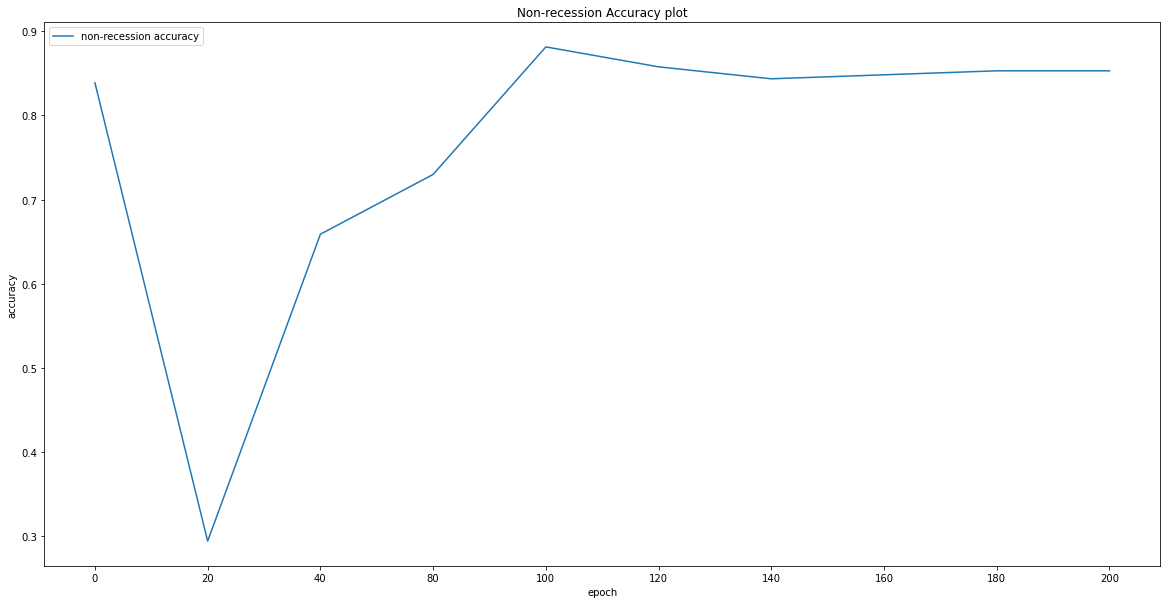

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

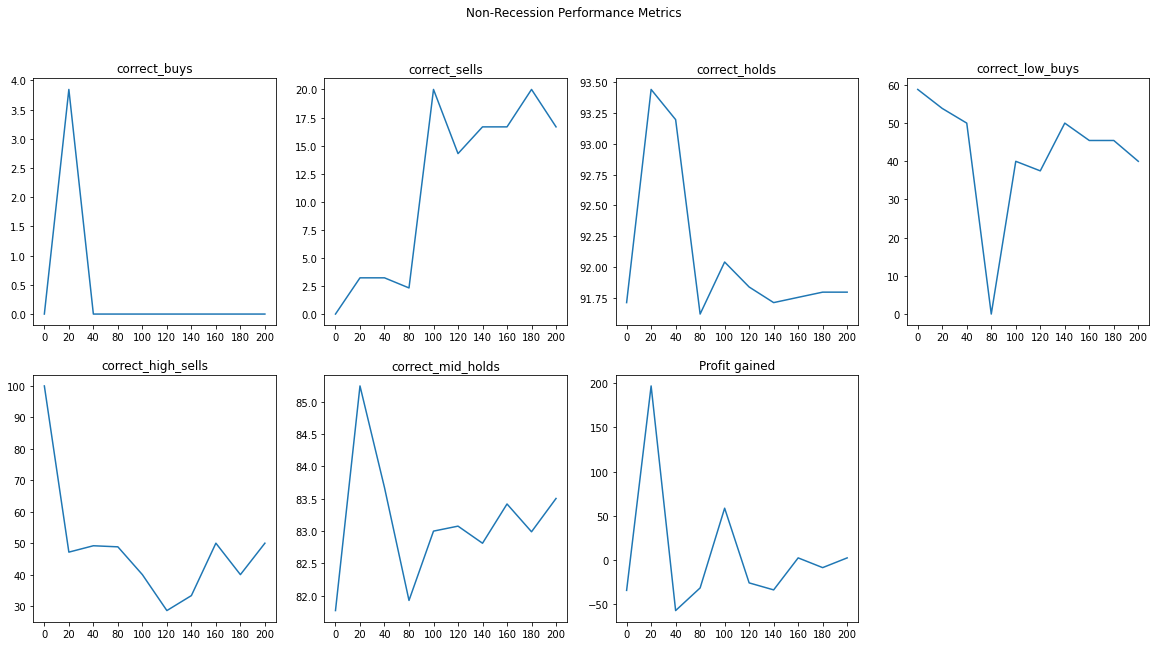

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

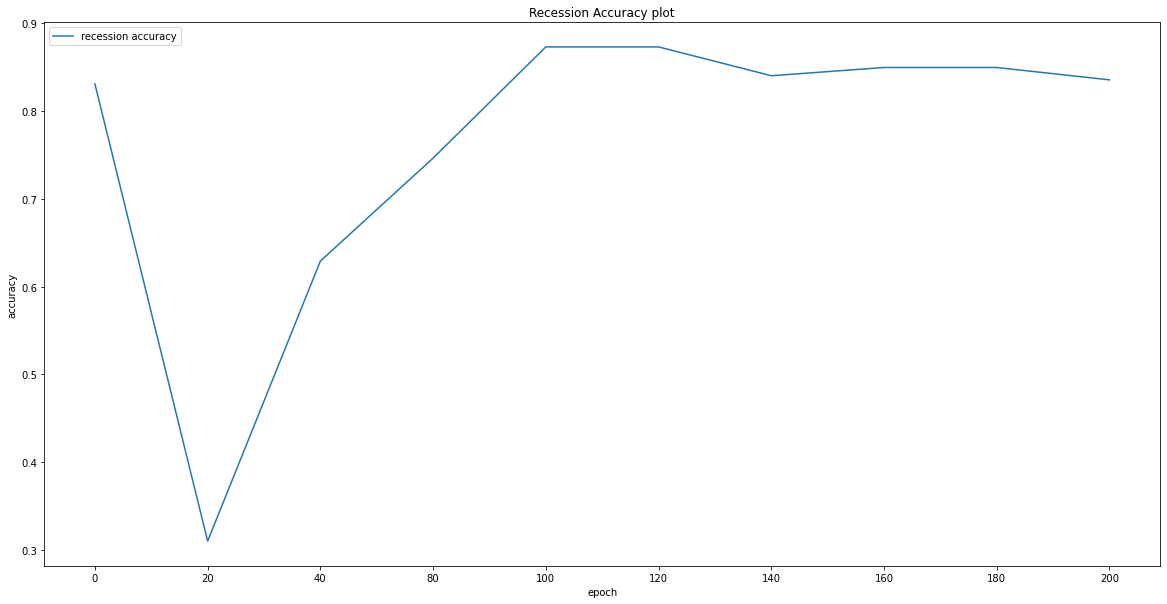

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

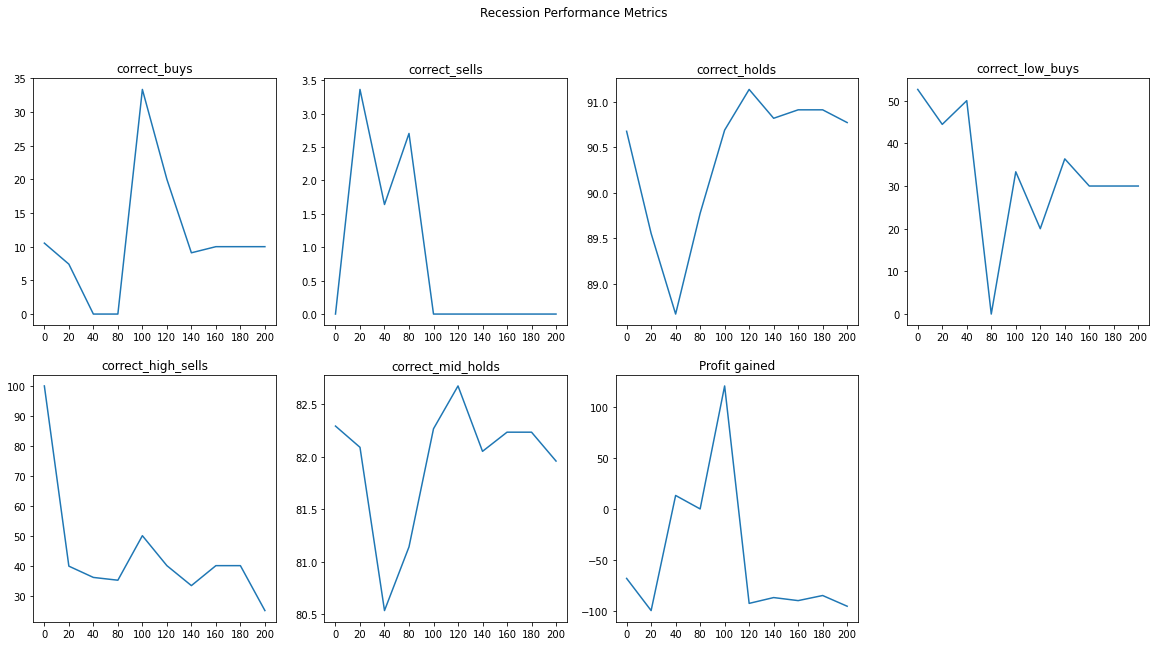

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### JP Morgan

In [56]:
nr_test_sets = ['JPM']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   104.589996  101.198442  -3.459880  84335200.0     2.0
2019-01-23   102.940002  101.466374 -21.874992  67251500.0     2.0
2019-01-24   102.680000  101.653086 -27.040213  55104800.0     2.0
2019-01-25   102.739998  101.820303 -32.628441  66401600.0     2.0
2019-01-28   103.389999  102.061795 -23.968276  80771000.0     2.0


In [57]:
r_test_sets = ['JPM']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   136.839996  137.690058 -77.454723  33776700.0     2.0
2020-01-23   136.679993  137.534664 -80.363881  26227600.0     2.0
2020-01-24   136.539993  137.381637 -69.867648  16881900.0     2.0
2020-01-27   133.149994  136.730615 -90.166021   1715500.0     1.0
2020-01-28   132.029999  136.007444 -79.004573 -11145000.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


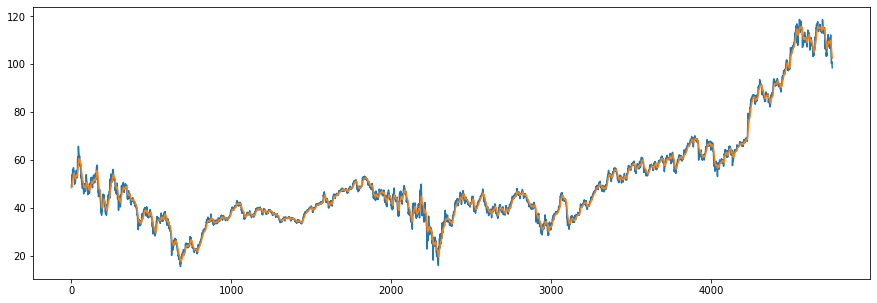

(4745, 64, 64)

In [58]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/JPM_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64)
y = np.array(y)

X.shape

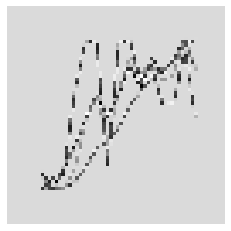

In [59]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [60]:
X = X/255

In [61]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [62]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [63]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [65]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('JPM')]
    y = nr_test_data['{}_y'.format('JPM')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('JPM'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'JPM')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'JPM'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'JPM'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('JPM')]
    y = r_test_data['{}_y'.format('JPM')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('JPM'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'JPM')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'JPM'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'JPM'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.715447154471545, 1: 7.3996101364522415, 2: 0.36559761148030434}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 44ms/step - loss: 0.2806 - accuracy: 0.4713 - mse: 0.4313 - weighted_accuracy: 0.3971 - weighted_mse: 0.4631 - val_loss: 0.2907 - val_accuracy: 0.9115 - val_mse: 0.3466 - val_weighted_accuracy: 0.9115 - val_weighted_mse: 0.3466
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2126 - accuracy: 0.3530 - mse: 0.7098 - weighted_accuracy: 0.4606 - weighted_mse: 0.6931 - val_loss: 0.2904 - val_accuracy: 0.0453 - val_mse: 0.3739 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3739
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1874 - accuracy: 0.3143 - mse: 0.9574 - weighted_accuracy: 0.5022 - weighted_mse: 0.9277 - val_loss: 0.2806 - val_accuracy: 0.0453 - val_mse: 0.4023 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4023
Epoch 4/20
30/30 [==============================] - 0

Epoch 1/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1282 - accuracy: 0.5066 - mse: 1.7307 - weighted_accuracy: 0.7474 - weighted_mse: 1.7625 - val_loss: 0.2167 - val_accuracy: 0.4763 - val_mse: 2.9487 - val_weighted_accuracy: 0.4763 - val_weighted_mse: 2.9487
Epoch 2/20
30/30 [==============================] - 0s 17ms/step - loss: 0.1259 - accuracy: 0.5298 - mse: 1.7306 - weighted_accuracy: 0.7521 - weighted_mse: 1.7585 - val_loss: 0.2385 - val_accuracy: 0.3857 - val_mse: 3.7125 - val_weighted_accuracy: 0.3857 - val_weighted_mse: 3.7125
Epoch 3/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1227 - accuracy: 0.5414 - mse: 1.7816 - weighted_accuracy: 0.7696 - weighted_mse: 1.8218 - val_loss: 0.1023 - val_accuracy: 0.8925 - val_mse: 1.4763 - val_weighted_accuracy: 0.8925 - val_weighted_mse: 1.4763
Epoch 4/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1201 - accuracy: 0.5506 - mse: 1.8018 - weighted_accuracy: 0.7671 - weighted

Epoch 1/20
30/30 [==============================] - 1s 17ms/step - loss: 0.0644 - accuracy: 0.8056 - mse: 2.7711 - weighted_accuracy: 0.9158 - weighted_mse: 3.0049 - val_loss: 0.1527 - val_accuracy: 0.8883 - val_mse: 11.3308 - val_weighted_accuracy: 0.8883 - val_weighted_mse: 11.3308
Epoch 2/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0641 - accuracy: 0.8177 - mse: 2.8879 - weighted_accuracy: 0.9163 - weighted_mse: 3.1159 - val_loss: 0.3067 - val_accuracy: 0.5469 - val_mse: 9.5655 - val_weighted_accuracy: 0.5469 - val_weighted_mse: 9.5655
Epoch 3/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0602 - accuracy: 0.8330 - mse: 2.9557 - weighted_accuracy: 0.9294 - weighted_mse: 3.2225 - val_loss: 0.4172 - val_accuracy: 0.2887 - val_mse: 4.1040 - val_weighted_accuracy: 0.2887 - val_weighted_mse: 4.1040
Epoch 4/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0536 - accuracy: 0.8512 - mse: 3.0870 - weighted_accuracy: 0.9437 - weight

Epoch 1/20
30/30 [==============================] - 1s 17ms/step - loss: 0.0222 - accuracy: 0.9576 - mse: 6.8351 - weighted_accuracy: 0.9826 - weighted_mse: 6.5093 - val_loss: 0.5785 - val_accuracy: 0.9115 - val_mse: 54.7995 - val_weighted_accuracy: 0.9115 - val_weighted_mse: 54.7995
Epoch 2/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0232 - accuracy: 0.9550 - mse: 6.9025 - weighted_accuracy: 0.9778 - weighted_mse: 6.7721 - val_loss: 0.4077 - val_accuracy: 0.6017 - val_mse: 10.3680 - val_weighted_accuracy: 0.6017 - val_weighted_mse: 10.3680
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0206 - accuracy: 0.9605 - mse: 7.0467 - weighted_accuracy: 0.9837 - weighted_mse: 6.8869 - val_loss: 0.5135 - val_accuracy: 0.9115 - val_mse: 33.8663 - val_weighted_accuracy: 0.9115 - val_weighted_mse: 33.8663
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0157 - accuracy: 0.9773 - mse: 7.2806 - weighted_accuracy: 0.9917 - we



Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.5678 - accuracy: 0.6164 - mse: 9.1289 - weighted_accuracy: 0.6164 - weighted_mse: 9.1289
Test loss: 0.5678367018699646
Test accuracy: 0.6164383292198181


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 36
actual holds but predicted sell: 34
actual predicted holds: 127
Percentage buys correct: 11.904761904761905%
Percentage sells correct: 8.108108108108109%
Percentage holds correct: 90.71428571428571%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 51.21951219512195%
Percentage high sells correct: 45.945945945945944%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.593570

30/30 [==============================] - 0s 13ms/step - loss: 0.0052 - accuracy: 0.9995 - mse: 14.3952 - weighted_accuracy: 0.9998 - weighted_mse: 13.0580 - val_loss: 0.3311 - val_accuracy: 0.8609 - val_mse: 14.3820 - val_weighted_accuracy: 0.8609 - val_weighted_mse: 14.3820
Epoch 13/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0049 - accuracy: 1.0000 - mse: 14.6168 - weighted_accuracy: 1.0000 - weighted_mse: 13.4324 - val_loss: 0.3388 - val_accuracy: 0.8714 - val_mse: 15.8686 - val_weighted_accuracy: 0.8714 - val_weighted_mse: 15.8686
Epoch 14/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0048 - accuracy: 1.0000 - mse: 14.8243 - weighted_accuracy: 1.0000 - weighted_mse: 13.5017 - val_loss: 0.3492 - val_accuracy: 0.8767 - val_mse: 17.2128 - val_weighted_accuracy: 0.8767 - val_weighted_mse: 17.2128
Epoch 15/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0048 - accuracy: 1.0000 - mse: 14.9766 - weighted_accuracy: 1.0000 - wei

Epoch 1/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0046 - accuracy: 1.0000 - mse: 15.9481 - weighted_accuracy: 1.0000 - weighted_mse: 14.6495 - val_loss: 0.4002 - val_accuracy: 0.8704 - val_mse: 19.4552 - val_weighted_accuracy: 0.8704 - val_weighted_mse: 19.4552
Epoch 2/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0047 - accuracy: 0.9995 - mse: 16.1412 - weighted_accuracy: 0.9998 - weighted_mse: 15.0038 - val_loss: 0.3807 - val_accuracy: 0.8451 - val_mse: 16.8717 - val_weighted_accuracy: 0.8451 - val_weighted_mse: 16.8717
Epoch 3/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0048 - accuracy: 1.0000 - mse: 16.2062 - weighted_accuracy: 1.0000 - weighted_mse: 14.6738 - val_loss: 0.3954 - val_accuracy: 0.8577 - val_mse: 18.7319 - val_weighted_accuracy: 0.8577 - val_weighted_mse: 18.7319
Epoch 4/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0046 - accuracy: 1.0000 - mse: 16.3819 - weighted_accuracy: 1.00

7/7 [==============================] - 0s 6ms/step - loss: 0.4995 - accuracy: 0.7626 - mse: 15.6931 - weighted_accuracy: 0.7626 - weighted_mse: 15.6931
Test loss: 0.4995241165161133
Test accuracy: 0.7625570893287659


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 11
actual holds but predicted buy: 16
actual holds but predicted sell: 16
actual predicted holds: 165
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 0.0%
Percentage holds correct: 89.67391304347827%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 36.8421052631579%
Percentage high sells correct: 37.5%
Percentage mid holds correct: 81.9672131147541%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price increase from previously bo

30/30 [==============================] - 1s 25ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 20.6116 - weighted_accuracy: 1.0000 - weighted_mse: 18.8260 - val_loss: 0.4763 - val_accuracy: 0.8166 - val_mse: 18.2987 - val_weighted_accuracy: 0.8166 - val_weighted_mse: 18.2987
Epoch 19/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 20.7788 - weighted_accuracy: 1.0000 - weighted_mse: 19.1600 - val_loss: 0.4559 - val_accuracy: 0.8525 - val_mse: 21.8532 - val_weighted_accuracy: 0.8525 - val_weighted_mse: 21.8532
Epoch 20/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 20.8768 - weighted_accuracy: 1.0000 - weighted_mse: 19.1297 - val_loss: 0.5071 - val_accuracy: 0.7945 - val_mse: 17.2562 - val_weighted_accuracy: 0.7945 - val_weighted_mse: 17.2562
Validation loss: 0.5071167349815369
Validation accuracy: 0.7945205569267273


Non-Recession Test


7/7 [==============================] - 0s 7ms/ste

Epoch 2/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 21.1181 - weighted_accuracy: 1.0000 - weighted_mse: 19.7001 - val_loss: 0.4616 - val_accuracy: 0.8746 - val_mse: 25.2111 - val_weighted_accuracy: 0.8746 - val_weighted_mse: 25.2111
Epoch 3/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 21.1093 - weighted_accuracy: 1.0000 - weighted_mse: 19.1357 - val_loss: 0.4837 - val_accuracy: 0.8261 - val_mse: 21.4394 - val_weighted_accuracy: 0.8261 - val_weighted_mse: 21.4394
Epoch 4/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 21.2238 - weighted_accuracy: 1.0000 - weighted_mse: 19.5836 - val_loss: 0.4528 - val_accuracy: 0.8514 - val_mse: 20.9534 - val_weighted_accuracy: 0.8514 - val_weighted_mse: 20.9534
Epoch 5/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 21.3100 - weighted_accuracy: 1.00

7/7 [==============================] - 0s 6ms/step - loss: 0.4863 - accuracy: 0.8174 - mse: 20.6573 - weighted_accuracy: 0.8174 - weighted_mse: 20.6573
Test loss: 0.4863487482070923
Test accuracy: 0.8173515796661377


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 11
actual holds but predicted buy: 6
actual holds but predicted sell: 14
actual predicted holds: 177
Percentage buys correct: 22.22222222222222%
Percentage sells correct: 0.0%
Percentage holds correct: 90.3061224489796%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 22.22222222222222%
Percentage high sells correct: 42.857142857142854%
Percentage mid holds correct: 83.07692307692308%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price increase from 

7/7 [==============================] - 0s 6ms/step - loss: 0.4923 - accuracy: 0.8165 - mse: 19.4915 - weighted_accuracy: 0.8165 - weighted_mse: 19.4915
Test loss: 0.4923228919506073
Test accuracy: 0.8165137767791748


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 12
actual holds but predicted sell: 12
actual predicted holds: 177
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 0.0%
Percentage holds correct: 91.70984455958549%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 30.76923076923077%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.375%


Capital: 100
Share price: $0.10350315623739602
Shares owned at the moment: 963
Cash capital at the moment: $0.05235830988195289


Price increase from previously bought: 

30/30 [==============================] - 1s 25ms/step - loss: 0.0040 - accuracy: 1.0000 - mse: 24.8836 - weighted_accuracy: 1.0000 - weighted_mse: 23.0448 - val_loss: 0.4908 - val_accuracy: 0.8577 - val_mse: 25.3369 - val_weighted_accuracy: 0.8577 - val_weighted_mse: 25.3369
Epoch 10/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0040 - accuracy: 1.0000 - mse: 24.9346 - weighted_accuracy: 1.0000 - weighted_mse: 22.8309 - val_loss: 0.6178 - val_accuracy: 0.7692 - val_mse: 20.4346 - val_weighted_accuracy: 0.7692 - val_weighted_mse: 20.4346
Epoch 11/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0040 - accuracy: 1.0000 - mse: 24.9836 - weighted_accuracy: 1.0000 - weighted_mse: 23.1858 - val_loss: 0.5055 - val_accuracy: 0.8683 - val_mse: 28.9985 - val_weighted_accuracy: 0.8683 - val_weighted_mse: 28.9985
Epoch 12/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0039 - accuracy: 1.0000 - mse: 25.0746 - weighted_accuracy: 1.0000 - wei

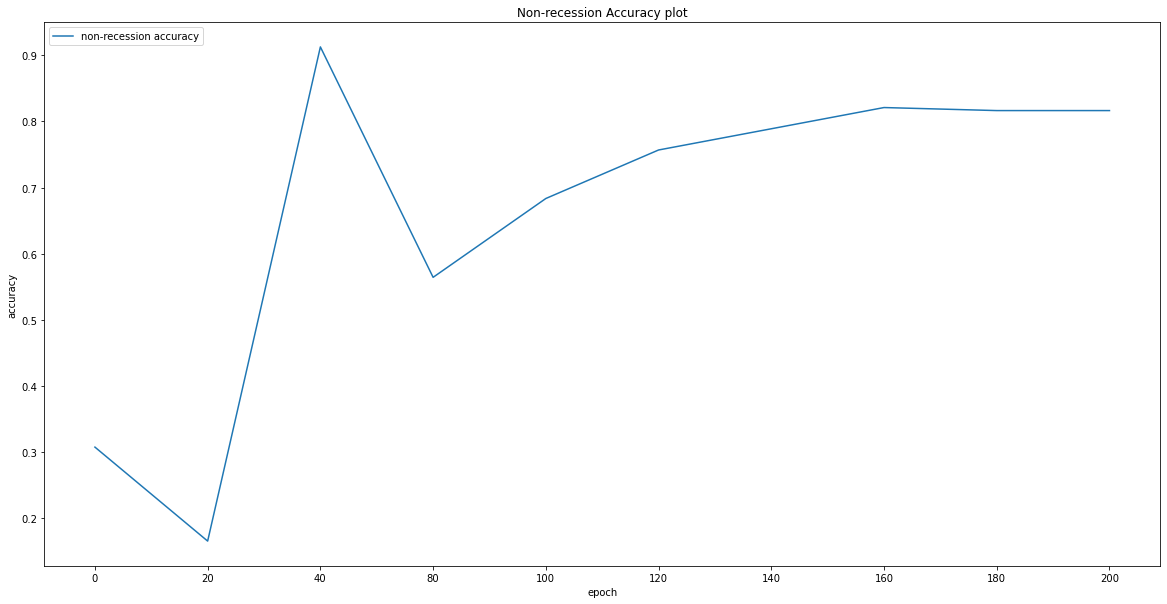

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

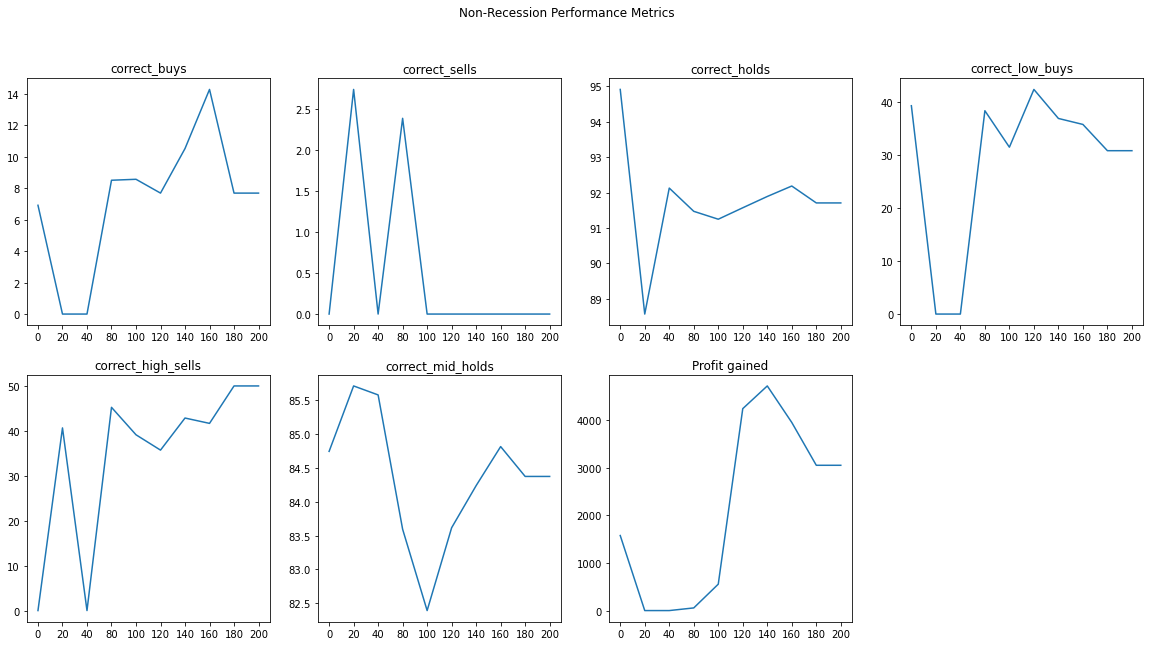

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

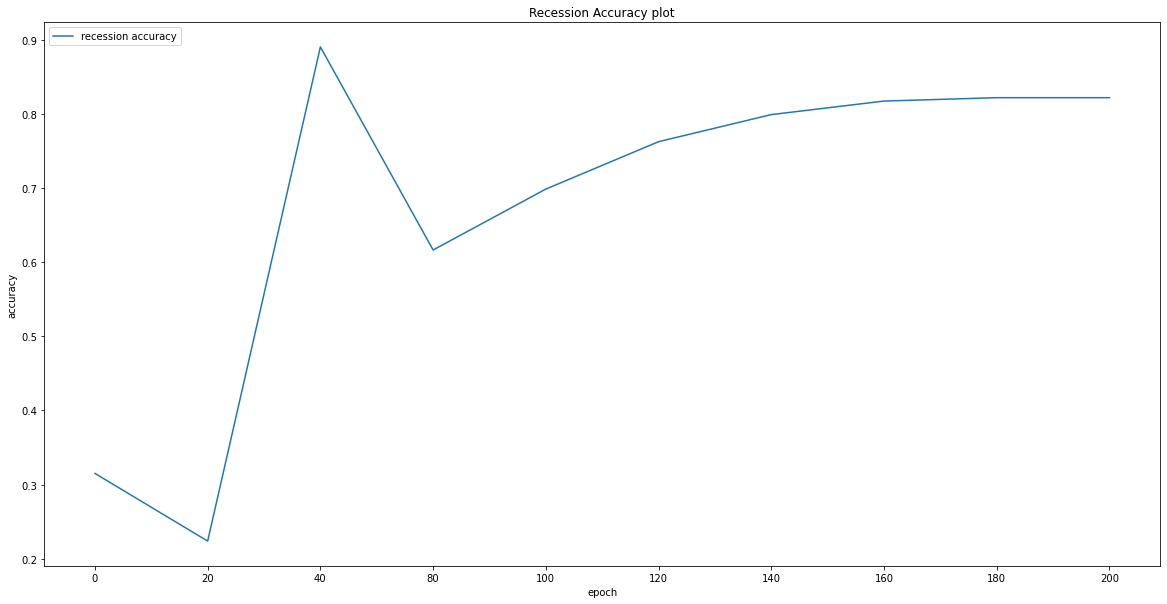

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

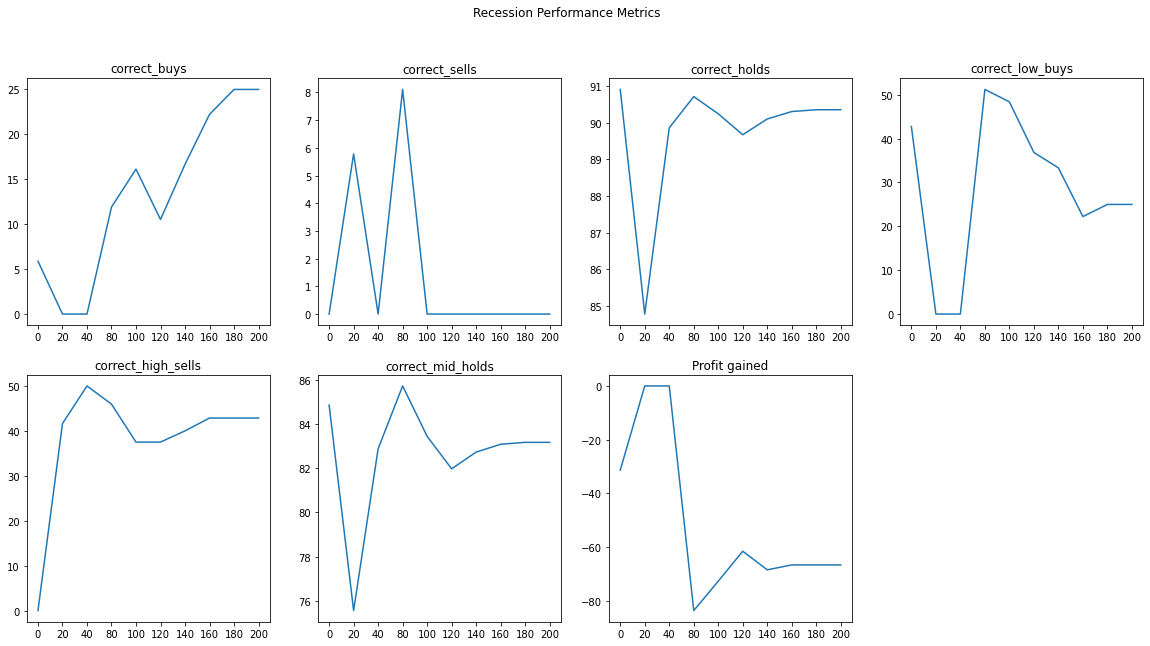

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### American Axle

In [70]:
nr_test_sets = ['AXL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        14.61  13.028180  -0.258404  23356600.0     2.0
2019-01-23        14.52  13.257691  -3.886001  21174700.0     2.0
2019-01-24        14.18  13.399585 -13.535906  19629300.0     2.0
2019-01-25        14.38  13.550418  -8.579880  20903300.0     2.0
2019-01-28        14.71  13.728815  -4.790414  22287500.0     2.0


In [71]:
r_test_sets = ['AXL']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         9.39  9.715390 -73.059349 -3592400.0     2.0
2020-01-23         9.34  9.657637 -75.342463 -4550300.0     2.0
2020-01-24         9.50  9.633386 -65.000010 -3092000.0     2.0
2020-01-27         9.31  9.583634 -66.883101 -4332600.0     2.0
2020-01-28         9.39  9.553844 -61.688301 -2300800.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


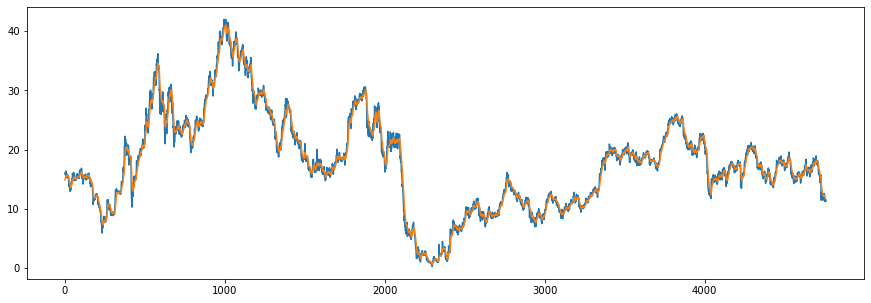

(4745, 64, 64)

In [72]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/AXL_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]

    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64)
y = np.array(y)

X.shape

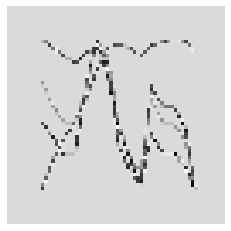

In [73]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [74]:
X = X/255

In [75]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [76]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [77]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [78]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [79]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('AXL')]
    y = nr_test_data['{}_y'.format('AXL')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('AXL'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'AXL')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'AXL'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'AXL'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('AXL')]
    y = r_test_data['{}_y'.format('AXL')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('AXL'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'AXL')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'AXL'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'AXL'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.272030651340996, 1: 7.3140655105973025, 2: 0.36686962404561707}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 40ms/step - loss: 0.2790 - accuracy: 0.5061 - mse: 0.4232 - weighted_accuracy: 0.3666 - weighted_mse: 0.4690 - val_loss: 0.2906 - val_accuracy: 0.9083 - val_mse: 0.3462 - val_weighted_accuracy: 0.9083 - val_weighted_mse: 0.3462
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.2155 - accuracy: 0.3954 - mse: 0.7038 - weighted_accuracy: 0.4464 - weighted_mse: 0.6977 - val_loss: 0.2915 - val_accuracy: 0.0464 - val_mse: 0.3696 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3696
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1924 - accuracy: 0.3588 - mse: 0.9498 - weighted_accuracy: 0.5077 - weighted_mse: 0.9175 - val_loss: 0.2865 - val_accuracy: 0.0464 - val_mse: 0.4028 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4028
Epoch 4/20
30/30 [==============================] - 0

7/7 [==============================] - 0s 4ms/step - loss: 0.1715 - accuracy: 0.6667 - mse: 2.1303 - weighted_accuracy: 0.6667 - weighted_mse: 2.1303
Test loss: 0.17154428362846375
Test accuracy: 0.6666666865348816


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 54
actual holds but predicted sell: 2
actual predicted holds: 141
Percentage buys correct: 6.779661016949152%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 89.80891719745223%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 48.275862068965516%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 84.71337579617834%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Pric



Capital at the end of test period if Buy and Hold: $59.80379974835048
profit gained: -40.19620025164952%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.697248      4.255319           10.0      92.546584   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         42.553191                40.0               85.0     -88.917927   

   buy_n_hold profit  
0           -40.1962  


Recession Test


7/7 [==============================] - 0s 4ms/step - loss: 0.2199 - accuracy: 0.6758 - mse: 4.5909 - weighted_accuracy: 0.6758 - weighted_mse: 4.5909
Test loss: 0.21987496316432953
Test accuracy: 0.6757990717887878


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 2
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 48
actual holds but predicted sell: 4
actual predicted holds: 145
Percentage buy

Epoch 19/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0228 - accuracy: 0.9581 - mse: 5.8181 - weighted_accuracy: 0.9846 - weighted_mse: 5.9822 - val_loss: 0.3590 - val_accuracy: 0.9062 - val_mse: 19.6533 - val_weighted_accuracy: 0.9062 - val_weighted_mse: 19.6533
Epoch 20/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0198 - accuracy: 0.9629 - mse: 6.1572 - weighted_accuracy: 0.9864 - weighted_mse: 6.2428 - val_loss: 0.2469 - val_accuracy: 0.6965 - val_mse: 8.3391 - val_weighted_accuracy: 0.6965 - val_weighted_mse: 8.3391
Validation loss: 0.24692848324775696
Validation accuracy: 0.6965226531028748


Non-Recession Test


7/7 [==============================] - 0s 4ms/step - loss: 0.3154 - accuracy: 0.6881 - mse: 8.5850 - weighted_accuracy: 0.6881 - weighted_mse: 8.5850
Test loss: 0.31543031334877014
Test accuracy: 0.6880733966827393


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted h

Epoch 1/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0185 - accuracy: 0.9694 - mse: 6.4317 - weighted_accuracy: 0.9888 - weighted_mse: 6.4818 - val_loss: 0.3981 - val_accuracy: 0.9062 - val_mse: 22.7002 - val_weighted_accuracy: 0.9062 - val_weighted_mse: 22.7002
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0167 - accuracy: 0.9742 - mse: 6.6859 - weighted_accuracy: 0.9905 - weighted_mse: 6.7833 - val_loss: 0.2245 - val_accuracy: 0.8672 - val_mse: 14.7021 - val_weighted_accuracy: 0.8672 - val_weighted_mse: 14.7021
Epoch 3/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0166 - accuracy: 0.9737 - mse: 6.9424 - weighted_accuracy: 0.9903 - weighted_mse: 6.9335 - val_loss: 0.2682 - val_accuracy: 0.8335 - val_mse: 14.4634 - val_weighted_accuracy: 0.8335 - val_weighted_mse: 14.4634
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0161 - accuracy: 0.9742 - mse: 7.2163 - weighted_accuracy: 0.9905 - we

7/7 [==============================] - 0s 5ms/step - loss: 0.3665 - accuracy: 0.8402 - mse: 17.8530 - weighted_accuracy: 0.8402 - weighted_mse: 17.8530
Test loss: 0.36645928025245667
Test accuracy: 0.8401826620101929


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 11
actual holds but predicted buy: 2
actual holds but predicted sell: 11
actual predicted holds: 184
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 89.32038834951456%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 100.0%
Percentage high sells correct: 45.45454545454545%
Percentage mid holds correct: 83.90243902439025%


Capital: 100
Share price: $0.620526318101011
Shares owned at the moment: 160
Cash capital at the moment: $0.4427575238737802


Price increase from previously bought: -4.7

7/7 [==============================] - 0s 5ms/step - loss: 0.3845 - accuracy: 0.8539 - mse: 17.2881 - weighted_accuracy: 0.8539 - weighted_mse: 17.2881
Test loss: 0.3845215439796448
Test accuracy: 0.853881299495697


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 4
actual holds but predicted sell: 6
actual predicted holds: 187
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 89.90384615384616%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 60.0%
Percentage high sells correct: 33.333333333333336%
Percentage mid holds correct: 84.54106280193237%


Capital: 100
Share price: $0.620526318101011
Shares owned at the moment: 160
Cash capital at the moment: $0.4427575238737802


Price increase from previously bought: 9.87595

7/7 [==============================] - 0s 5ms/step - loss: 0.4140 - accuracy: 0.8447 - mse: 18.8235 - weighted_accuracy: 0.8447 - weighted_mse: 18.8235
Test loss: 0.41395172476768494
Test accuracy: 0.844748854637146


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 6
actual holds but predicted sell: 6
actual predicted holds: 185
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 89.80582524271844%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 42.857142857142854%
Percentage high sells correct: 33.333333333333336%
Percentage mid holds correct: 84.39024390243902%


Capital: 100
Share price: $0.620526318101011
Shares owned at the moment: 160
Cash capital at the moment: $0.4427575238737802


Price increase from previously 

7/7 [==============================] - 0s 4ms/step - loss: 0.3790 - accuracy: 0.8716 - mse: 19.7538 - weighted_accuracy: 0.8716 - weighted_mse: 19.7538
Test loss: 0.3789729177951813
Test accuracy: 0.8715596199035645


number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 7
actual holds but predicted buy: 6
actual holds but predicted sell: 6
actual predicted holds: 190
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 92.6829268292683%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 14.285714285714286%
Percentage high sells correct: 16.666666666666668%
Percentage mid holds correct: 85.7843137254902%


Capital: 100
Share price: $0.9376555943216209
Shares owned at the moment: 106
Cash capital at the moment: $0.3351803961634232


Price increase from previously bough

30/30 [==============================] - 0s 14ms/step - loss: 0.0042 - accuracy: 1.0000 - mse: 23.1883 - weighted_accuracy: 1.0000 - weighted_mse: 21.4322 - val_loss: 0.4207 - val_accuracy: 0.8419 - val_mse: 22.3541 - val_weighted_accuracy: 0.8419 - val_weighted_mse: 22.3541
Epoch 14/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 23.3978 - weighted_accuracy: 1.0000 - weighted_mse: 21.7122 - val_loss: 0.4414 - val_accuracy: 0.8588 - val_mse: 25.8398 - val_weighted_accuracy: 0.8588 - val_weighted_mse: 25.8398
Epoch 15/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 23.4866 - weighted_accuracy: 1.0000 - weighted_mse: 21.7184 - val_loss: 0.4197 - val_accuracy: 0.8799 - val_mse: 26.1731 - val_weighted_accuracy: 0.8799 - val_weighted_mse: 26.1731
Epoch 16/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 23.6115 - weighted_accuracy: 1.0000 - wei

30/30 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 24.3259 - weighted_accuracy: 1.0000 - weighted_mse: 22.3449 - val_loss: 0.4175 - val_accuracy: 0.8725 - val_mse: 23.5633 - val_weighted_accuracy: 0.8725 - val_weighted_mse: 23.5633
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 24.4591 - weighted_accuracy: 1.0000 - weighted_mse: 22.8458 - val_loss: 0.4001 - val_accuracy: 0.8483 - val_mse: 22.0929 - val_weighted_accuracy: 0.8483 - val_weighted_mse: 22.0929
Epoch 6/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 24.4730 - weighted_accuracy: 1.0000 - weighted_mse: 22.6337 - val_loss: 0.4311 - val_accuracy: 0.8135 - val_mse: 20.3156 - val_weighted_accuracy: 0.8135 - val_weighted_mse: 20.3156
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0041 - accuracy: 1.0000 - mse: 24.5998 - weighted_accuracy: 1.0000 - weight

Epoch 1/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0040 - accuracy: 1.0000 - mse: 25.8542 - weighted_accuracy: 1.0000 - weighted_mse: 23.9285 - val_loss: 0.4438 - val_accuracy: 0.8725 - val_mse: 28.8691 - val_weighted_accuracy: 0.8725 - val_weighted_mse: 28.8691
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0040 - accuracy: 1.0000 - mse: 25.9182 - weighted_accuracy: 1.0000 - weighted_mse: 24.2592 - val_loss: 0.4311 - val_accuracy: 0.8736 - val_mse: 27.2186 - val_weighted_accuracy: 0.8736 - val_weighted_mse: 27.2186
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0040 - accuracy: 1.0000 - mse: 26.0144 - weighted_accuracy: 1.0000 - weighted_mse: 24.1542 - val_loss: 0.4641 - val_accuracy: 0.8936 - val_mse: 30.9833 - val_weighted_accuracy: 0.8936 - val_weighted_mse: 30.9833
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0040 - accuracy: 1.0000 - mse: 26.0686 - weighted_accuracy: 1.00

7/7 [==============================] - 0s 4ms/step - loss: 0.5089 - accuracy: 0.8402 - mse: 25.5251 - weighted_accuracy: 0.8402 - weighted_mse: 25.5251
Test loss: 0.5088775753974915
Test accuracy: 0.8401826620101929


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 7
actual holds but predicted sell: 6
actual predicted holds: 184
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 89.7560975609756%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 37.5%
Percentage high sells correct: 33.333333333333336%
Percentage mid holds correct: 84.31372549019608%


Capital: 100
Share price: $0.620526318101011
Shares owned at the moment: 160
Cash capital at the moment: $0.4427575238737802


Price increase from previously bought: -4.7149

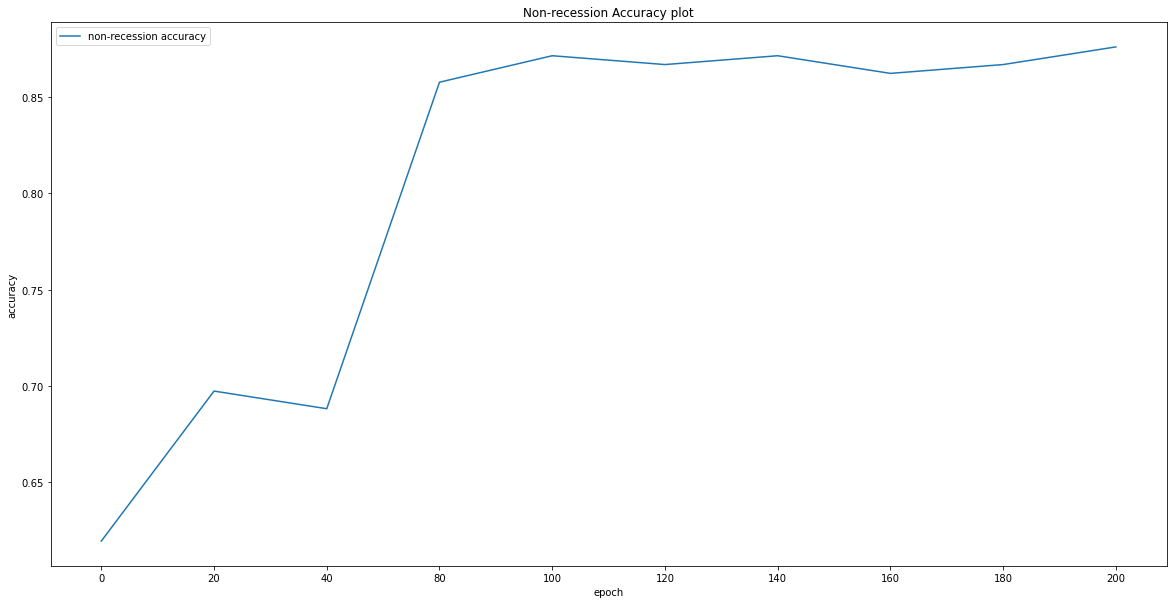

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

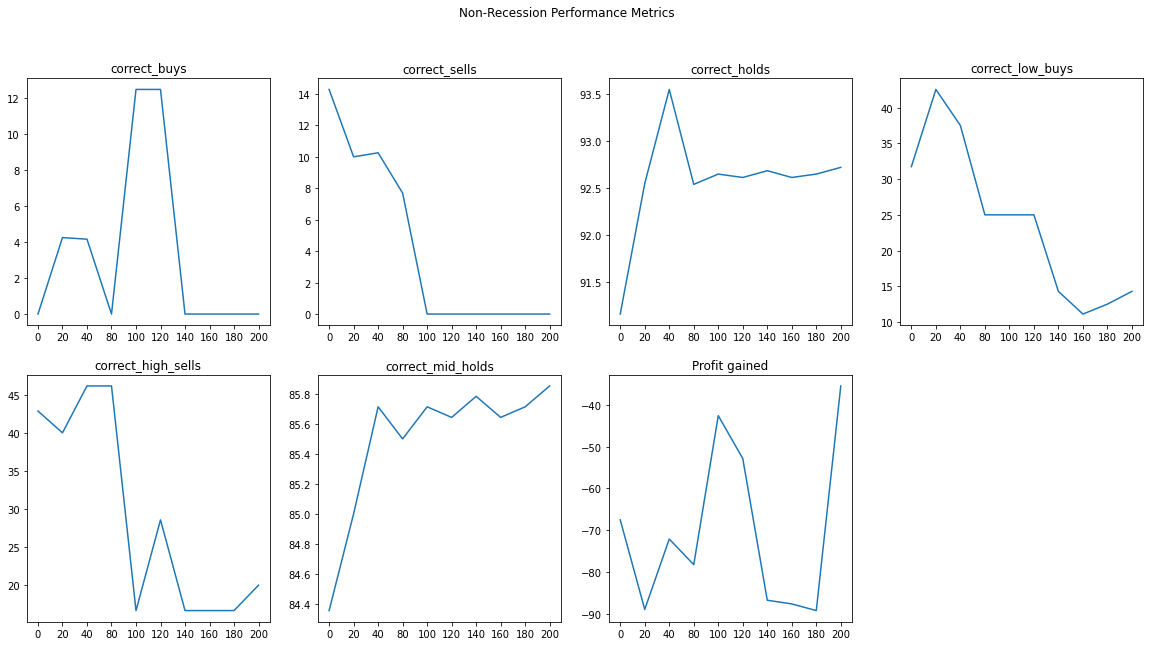

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

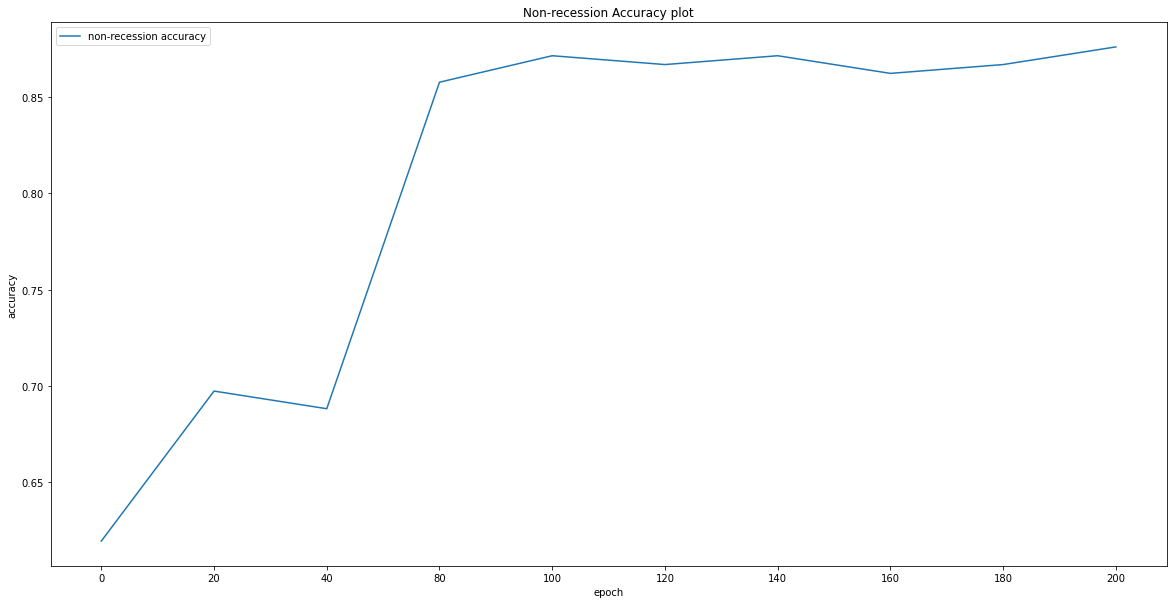

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

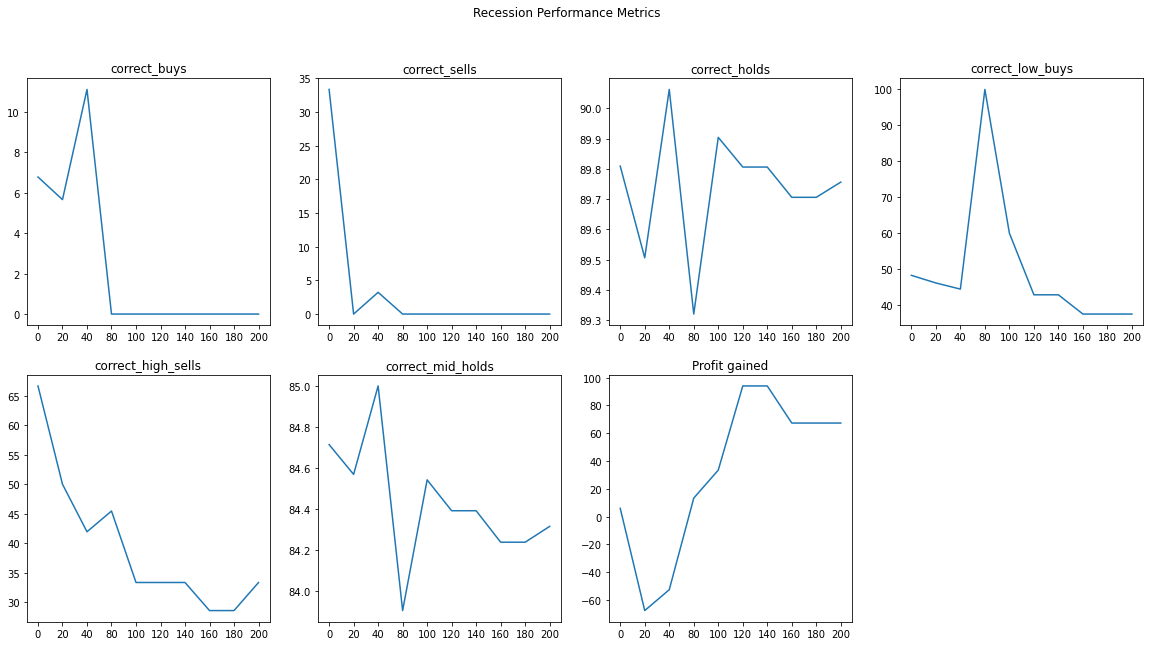

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")